In [1]:

# %%
import os
import glob
import copy
import sys
import pickle 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np 


from rslds_visualization_utils import plot_states_and_neurons, plot_states_and_neurons_state_list
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap

sys.path.append("/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/")
sys.path.append('/Users/bennetsakelaris/Documents/Obsidian Vault/Worms/wormcode/Code+Notes 09-24-24/collab/')

sys.path.append("/Users/friederikebuck/Downloads/worm notes/worm_code/")


from get_data.read_neuro_beh_data import get_exp_features, load_json
from get_data.process_neural_data import get_derivative_of_neural_activity, get_neural_activity_from_labels, get_neural_activity_and_labels
from beh_classification.behavior_features import get_behavior_features
from get_data.read_neuro_beh_data import get_exp_features, load_json

sys.path.append('/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/')
from beh_classification.process_midlines.midline_utils import save_as_csv, load_from_csv, convert_coordinates_to_angles
from rslds_motor_state_class_fncs import get_motor_state_start_end_is_rslds_start_end_specific

from load_data_fncs import load_all_data, get_exp_dates

from plotting_utils import plot_probabilities_hist, plot_hist_across_conditins_and_get_KS_stats
from categorize_reor_fncs import find_runs, make_masks, get_reor_mat, get_zero_crossing_indices, count_zero_crossing, get_date_to_state_bin, get_all_states_bin
from visualize_state_fncs import get_motor_state_start_end_is_rslds_start_end_specific_1, get_features_from_track_start_end_is, remove_nans, visualize_transition_matrix, get_rslds_pair_counts, plot_feature_hists_motor_states, get_pair_wise_avgs, plot_neural_activity_heatmap, plot_neural_activity
    

In [2]:


T = 1599

motor_state_num_to_name = {
    0:"fwd", 
    1:"rev", 
    2:"turn", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}
rslds_state_num_to_name = {
    0:"fwd-like", 
    1:"rev-like", 
    2:"turn-like", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}

rslds_state_to_color = {
    0: "salmon", 
    1: "dodgerblue", 
    2: "green"
}


comp = "mac"
if comp == "hpc":
  project_dir = "/ru-auth/local/home/fbuck/scratch/WholeBrainImaging/keypt_moseq/projects/_1/"#sys.argv[1]+"_1"#/Volumes/FB1/moseq_project_dir/WholeBrainImagingAnalysis_1/"
  video_dir = "/ru-auth/local/home/fbuck/scratch/WholeBrainImaging/outputs_hpc/" #"/Users/friederikebuck/Desktop/MBL/project/outputs/"  #when al subdirs with vids or keypoints are stored 
  video_clip_dir = "/ru-auth/local/home/fbuck/scratch/WholeBrainImaging/outputs_hpc/vid_clips/"

else: 
#   project_dir = "/Volumes/FB1/moseq_project_dir_and_outputs/_1/"
# moseq_project_dir = ""
    project_dir = "/Volumes/FB1/moseq_project_dir_and_outputs/_1/"
    project_dir = "/Volumes/FB_data_ana/moseq_project_dir_and_outputs/_1/"
    video_dir = "/Users/friederikebuck/Desktop/MBL/project/outputs/" #"/Users/friederikebuck/Desktop/MBL/project/outputs/"  #when al subdirs with vids or keypoints are stored 
    video_clip_dir = "/Users/friederikebuck/Desktop/MBL/project/vid_clips/"
    save_dir = f"/Volumes/FB_data_ana/moseq_project_dir_and_outputs_figs/"

    # os.makedirs(save_dir, exist_ok=True)

json_dir = "/Users/friederikebuck/Desktop/MBL/project/data/Neuropal_no_heat/"
h5_dir ="/Users/friederikebuck/Desktop/MBL/project/data/processed_h5/"
beh_data_dir_parent = "/Users/friederikebuck/Desktop/MBL/project/outputs/"
        
full_traces, full_neural_labels, full_beh_classification, full_beh_data = load_all_data()
velocity_og = np.array([full_beh_data[i]["velocity"][0:1599] for i in range(len(full_beh_data))])
acceleration_og = np.array([full_beh_data[i]["acceleration"][1:1600] for i in range(len(full_beh_data))])
head_curvature_og = np.array([full_beh_data[i]["head_angle"][0:1599] for i in range(len(full_beh_data))])
worm_curvature_og = np.array([full_beh_data[i]["worm_curvature"][0:1599] for i in range(len(full_beh_data))])
pumping_og = np.array([full_beh_data[i]["pumping"][0:1599] for i in range(len(full_beh_data))])
body_angle_mag_og = np.array([full_beh_data[i]["body_angle_mag"][0:1599] for i in range(len(full_beh_data))])
midlines_og =  np.array([full_beh_data[i]["midlines"][0:1599] for i in range(len(full_beh_data))])
body_angles_og =  np.array([full_beh_data[i]["body_angles"][0:1599] for i in range(len(full_beh_data))])

velocity = copy.deepcopy(velocity_og)
acceleration = copy.deepcopy(acceleration_og)
head_curvature = copy.deepcopy(head_curvature_og)
worm_curvature = copy.deepcopy(worm_curvature_og)
pumping = copy.deepcopy(pumping_og)
body_angle_mag =copy.deepcopy(body_angle_mag_og)
midlines =copy.deepcopy( midlines_og)
body_angles = copy.deepcopy(body_angles_og)




pdf_save_dir = "/Users/friederikebuck/Downloads/worm notes/rslds_all_dates/"
os.makedirs(pdf_save_dir, exist_ok=True)
directories = glob.glob(json_dir+"*.json") #get filename/paths of all the json files
exp_dates = [directory.split("/")[-1].split(".")[0] for directory in directories] #extract the exp_dates
# exp_date_to_jpeg_dir = {exp_date: exp_to_jpeg_dir(exp_date) for exp_date in exp_dates} ###for not wusing 10sx eesmapled..s hould use confocal..? go from rslds to 20 

   
kappas = np.logspace(3,7,5)
kappas = [kappas[0]]
decrease_kappa_factor = 10
num_ar_iters = 50
num_full_iters = 200
time_bin = 10
prefix = 'my_kappa_scan'
# for kappa in kappas: #kappas[:2]
kappa = kappas[0]
print(f"Fitting model with kappa={kappa}")
model_name = f'{prefix}-{kappa}'
# fig_save_dir = os.path.join(save_dir, model_name)

np.random.seed(0)

foldername = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/test_rslds_QM_run_061325/model_selection/top_2_combined/"
items = np.array(os.listdir(foldername))
folders = np.array(["." not in directory for directory in items], dtype=bool)
folders = items[folders]

folder = folders[0]


with open(foldername+"/Y.npy", 'rb') as handle:  
    Y = pickle.load(handle)


with open(foldername+folder+"/saved_data/prior.npy", 'rb') as handle:
    global_worm = pickle.load(handle)
    global_worm.D = int(global_worm.D)

with open(foldername+folder+"/saved_data/prior_q.npy", 'rb') as handle:
    q = pickle.load(handle)
    

slds = global_worm

neural_labels = np.load(foldername+"/neurons.npy", allow_pickle=True)


print(np.array(Y).shape)

print(len(neural_labels))



slds = global_worm
# get estimated latents, states
q_x = q.mean_continuous_states
q_z = [slds.most_likely_states(q_x[w], Y[w]) for w in range(len(q_x))]

z = [beh_classification["is_fwd"][0:1599]+ 2*beh_classification["is_rev"][0:1599]+ 4*beh_classification["is_pause"][0:1599]+3*beh_classification["is_turn"][0:1599]-1 for beh_classification in full_beh_classification]
q_z= np.array(q_z)
print(q_z.shape)
z = np.array(z)
print(z.shape)

Worm 0, date: 2022-06-14-01
Worm 1, date: 2023-01-23-08
Worm 2, date: 2022-06-28-07
Worm 3, date: 2022-07-15-12
Worm 4, date: 2023-01-19-01
Worm 5, date: 2022-08-02-01
Worm 6, date: 2022-06-14-07
Worm 7, date: 2022-06-28-01
Worm 8, date: 2023-01-23-15
Worm 9, date: 2022-07-26-01
Worm 10, date: 2023-01-19-15
Worm 11, date: 2023-03-07-01
Worm 12, date: 2022-06-14-13
Worm 13, date: 2023-01-23-21
Worm 14, date: 2023-01-19-22
Worm 15, date: 2023-01-23-01
Worm 16, date: 2023-01-17-01
Worm 17, date: 2022-07-20-01
Worm 18, date: 2023-01-09-28
Worm 19, date: 2023-01-19-08
Worm 20, date: 2022-07-15-06


/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:11: RuntimeWarning: Mean of empty slice
  body_angles = body_angles-np.nanmean(body_angles, axis = 1)[:, None]
/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:15: RuntimeWarning: Mean of empty slice
  centroids = np.nanmean(midlines, axis = 1)


Fitting model with kappa=1000.0
(21, 1599, 138)
138
(21, 1599)
(21, 1599)


In [3]:

motor_state_num_to_name = {
    0:"fwd", 
    1:"rev", 
    2:"turn", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}
rslds_state_num_to_name = {
    0:"fwd-like", 
    1:"rev-like", 
    2:"turn-like", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}

feature_to_dict = {
    "n body swings":
        {
        # "exp_date_to_feature":  {date: get_body_angle_mag_from_midline(midline)[1][:, 20] for date,midline in exp_date_to_midlines.items() },
        "bins": np.arange(0, 15, 1), 
         "feature_fnc": lambda body_angle_over_event: len(get_zero_crossing_indices(body_angle_over_event)), 
         "ylim": [0, 0.5],
          "ylabel": "P(n body swings)", 
        #   "feature_mat": np.concatenate([get_body_angle_mag_from_midline(midline)[1][:, 20][:, None] for date, midline in exp_date_to_midlines.items()], axis = 1), 
        "feature_mat": body_angles[:,:, 20]
    },
        
    "duration (s)": {
        "exp_date_to_feature": "", 
        "bins": np.linspace(0, 45, 25), 
         "feature_fnc": lambda x: np.nanmax(x), 
         "ylim": [0, 0.5],
          "ylabel": "P(duration)", 
          "feature_mat": "", 
        
    },
        
    "curviness (radians)":
        {
            # "exp_date_to_feature": exp_date_to_body_angle_mag, 
         "bins": np.linspace(0,16, 25), 
         "feature_fnc": lambda x: np.nanmax(x), 
         "ylim": [0, 0.2], 
          "ylabel": "P(curviness)", 
        #   "feature_mat": np.concatenate([exp_date_to_body_angle_mag[date][:, None] for date in exp_dates], axis = 1)
        "feature_mat": body_angle_mag
        } , 
    # "velocity (mm/s)": (exp_date_to_velocity,   np.linspace(0,0.35, 50),  lambda x: np.max(np.abs(x))), 
    "speed (um/s)": 
        {
            # "exp_date_to_feature": exp_date_to_velocity, 
         "bins":  np.linspace(0,350, 25), 
         "feature_fnc": lambda x:np.nanmax(np.abs(x)), 
         "ylim": [0, 0.24], 
         "ylabel": "P(max speed)", 
        #  "feature_mat": np.concatenate([exp_date_to_velocity[date][:, None] for date in exp_dates], axis = 1)
        "feature_mat": velocity
        } , 
    # # "head angle": (exp_date_to_head_angle,  50,  lambda x: np.mean(x)),#np.arange(0, 6, 0.01)), , 
    "acceleration (um/s^2)": 
        {
            # "exp_date_to_feature": exp_date_to_acceleration, 
         "bins":  np.linspace(0,0.015, 25),
         "feature_fnc":  lambda x: np.nanmax(np.abs(x)), 
         "ylim": [0, 0.14] ,
          "ylabel": "P(max acceleration)", 
        #   "feature_mat": np.concatenate([exp_date_to_acceleration[date][:, None] for date in exp_dates], axis = 1). 
         "feature_mat": acceleration
        } , 
    
}


feature n body swings
0 308 309
feature_mat [[ 0.75069186  0.8530723   0.61045668 ...  0.80785179  0.85156926
   0.68753456]
 [-0.52942306 -0.50424263 -0.30490284 ... -0.44690128 -0.16495481
   0.1466795 ]
 [-0.39671515 -0.62073633 -0.58694857 ... -0.1029389   0.1200139
  -0.47546333]
 ...
 [ 0.42088362  0.17736697 -0.36855872 ...  0.09702885 -0.21575543
   0.10682776]
 [-0.24090664 -0.12106706  0.31253386 ...  0.6713675   0.61231731
   0.51218593]
 [-0.02318289 -0.21572662 -0.37312585 ...  0.15573728 -0.11492031
  -0.27777304]]
0 615 620
feature_mat [[ 0.75069186  0.8530723   0.61045668 ...  0.80785179  0.85156926
   0.68753456]
 [-0.52942306 -0.50424263 -0.30490284 ... -0.44690128 -0.16495481
   0.1466795 ]
 [-0.39671515 -0.62073633 -0.58694857 ... -0.1029389   0.1200139
  -0.47546333]
 ...
 [ 0.42088362  0.17736697 -0.36855872 ...  0.09702885 -0.21575543
   0.10682776]
 [-0.24090664 -0.12106706  0.31253386 ...  0.6713675   0.61231731
   0.51218593]
 [-0.02318289 -0.21572662 -0.37312

NameError: name 'np' is not defined

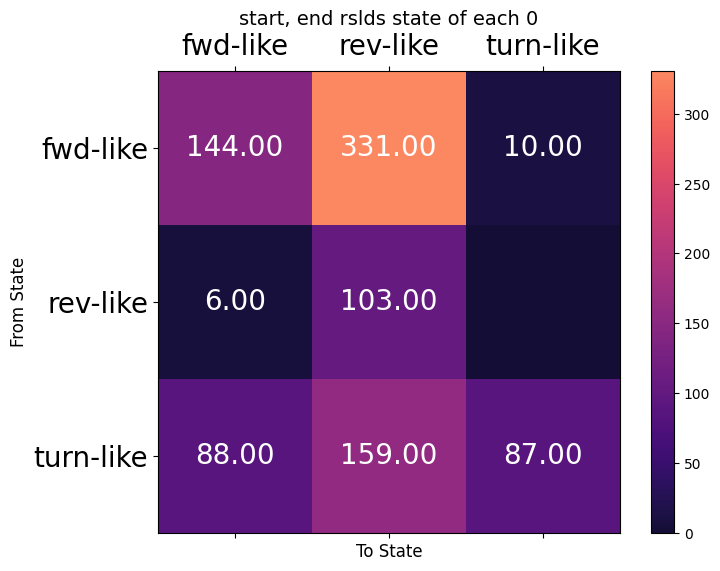

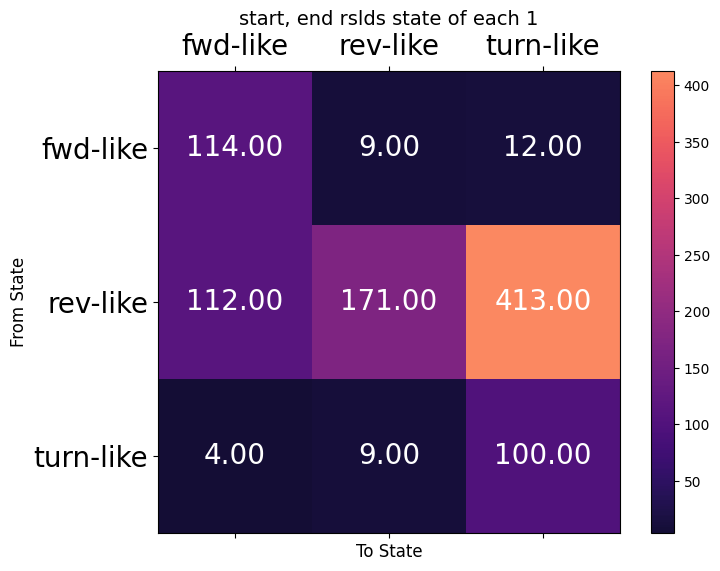

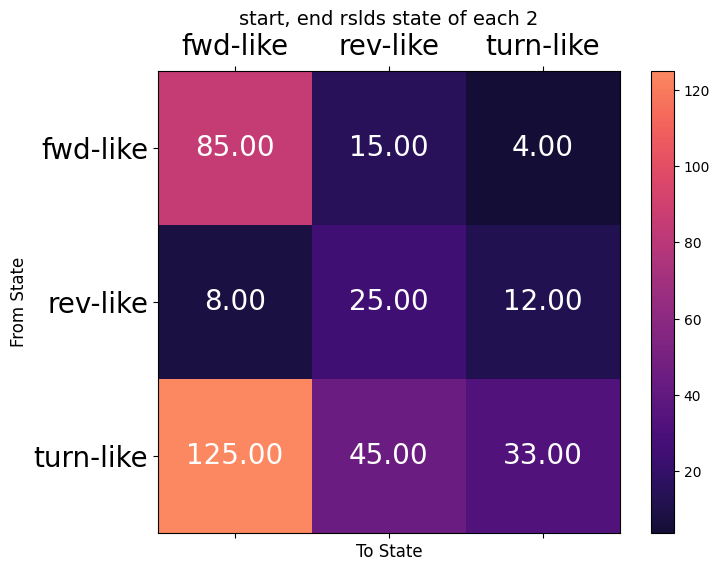

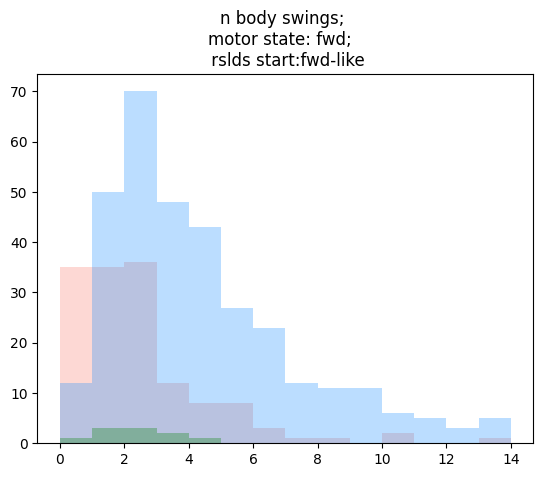

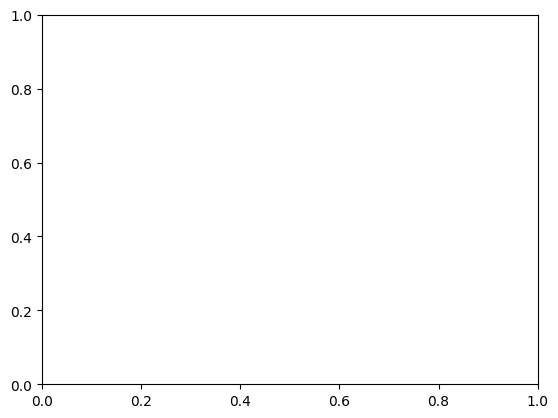

In [ ]:
from plotting_utils import plot_probabilities_hist, plot_hist_across_conditins_and_get_KS_stats
from categorize_reor_fncs import find_runs, make_masks, get_reor_mat, get_zero_crossing_indices, count_zero_crossing, get_date_to_state_bin, get_all_states_bin
from visualize_state_fncs import get_motor_state_start_end_is_rslds_start_end_specific_1, get_features_from_track_start_end_is, remove_nans, visualize_transition_matrix, get_rslds_pair_counts, plot_feature_hists_motor_states, get_pair_wise_avgs, plot_neural_activity_heatmap, plot_neural_activity
    
rslds_states = [0,1,2]
motor_states = [0,1,2]
state_to_label,  state_to_track_start_end_is = get_motor_state_start_end_is_rslds_start_end_specific_1(motor_states, rslds_states, z, q_z)
feature_state_to_feature_vals = get_features_from_track_start_end_is(feature_to_dict, state_to_track_start_end_is )
get_rslds_pair_counts(state_to_track_start_end_is, state_to_label, motor_states, rslds_states, plot= True, rslds_state_num_to_name = rslds_state_num_to_name )
plot_feature_hists_motor_states(feature_state_to_feature_vals,feature_to_dict, rslds_state_to_color,  state_to_label, motor_states, rslds_states, motor_state_num_to_name, 
                                    rslds_state_num_to_name,)



motor_states = [3,4,5,6]
rslds_states = [0,1,2]

reor_mat =  get_reor_mat(z)
state_to_label,  state_to_track_start_end_is = get_motor_state_start_end_is_rslds_start_end_specific_1(motor_states, rslds_states, reor_mat, q_z)
feature_state_to_feature_vals = get_features_from_track_start_end_is(feature_to_dict, state_to_track_start_end_is )
get_rslds_pair_counts(state_to_track_start_end_is, state_to_label, motor_states, rslds_states, plot= True, rslds_state_num_to_name = rslds_state_num_to_name )
plot_feature_hists_motor_states(feature_state_to_feature_vals,feature_to_dict, rslds_state_to_color,  state_to_label, motor_states, rslds_states,  motor_state_num_to_name, 
                                    rslds_state_num_to_name)



feature neural_activity_mean
(0, 0) 144
skipping,  (0, 2) 10
skipping,  (1, 0) 6
skipping,  (1, 2) 0
(0, 1) 331
skipping,  (0, 2) 10
skipping,  (1, 0) 6
skipping,  (1, 2) 0
(1, 1) 103
skipping,  (0, 2) 10
skipping,  (1, 0) 6
skipping,  (1, 2) 0
(2, 0) 88
skipping,  (0, 2) 10
skipping,  (1, 0) 6
skipping,  (1, 2) 0
(2, 1) 159
skipping,  (0, 2) 10
skipping,  (1, 0) 6
skipping,  (1, 2) 0
(2, 2) 87
skipping,  (0, 2) 10
skipping,  (1, 0) 6
skipping,  (1, 2) 0
(0, 0) 114
skipping,  (0, 1) 9
skipping,  (0, 2) 12
skipping,  (2, 0) 4
skipping,  (2, 1) 9
(1, 0) 112
skipping,  (0, 1) 9
skipping,  (0, 2) 12
skipping,  (2, 0) 4
skipping,  (2, 1) 9
(1, 1) 171
skipping,  (0, 1) 9
skipping,  (0, 2) 12
skipping,  (2, 0) 4
skipping,  (2, 1) 9
(1, 2) 413
skipping,  (0, 1) 9
skipping,  (0, 2) 12
skipping,  (2, 0) 4
skipping,  (2, 1) 9
(2, 2) 100
skipping,  (0, 1) 9
skipping,  (0, 2) 12
skipping,  (2, 0) 4
skipping,  (2, 1) 9
(0, 0) 85
skipping,  (0, 2) 4
skipping,  (1, 0) 8
skipping,  (1, 2) 12
(0, 1) 15


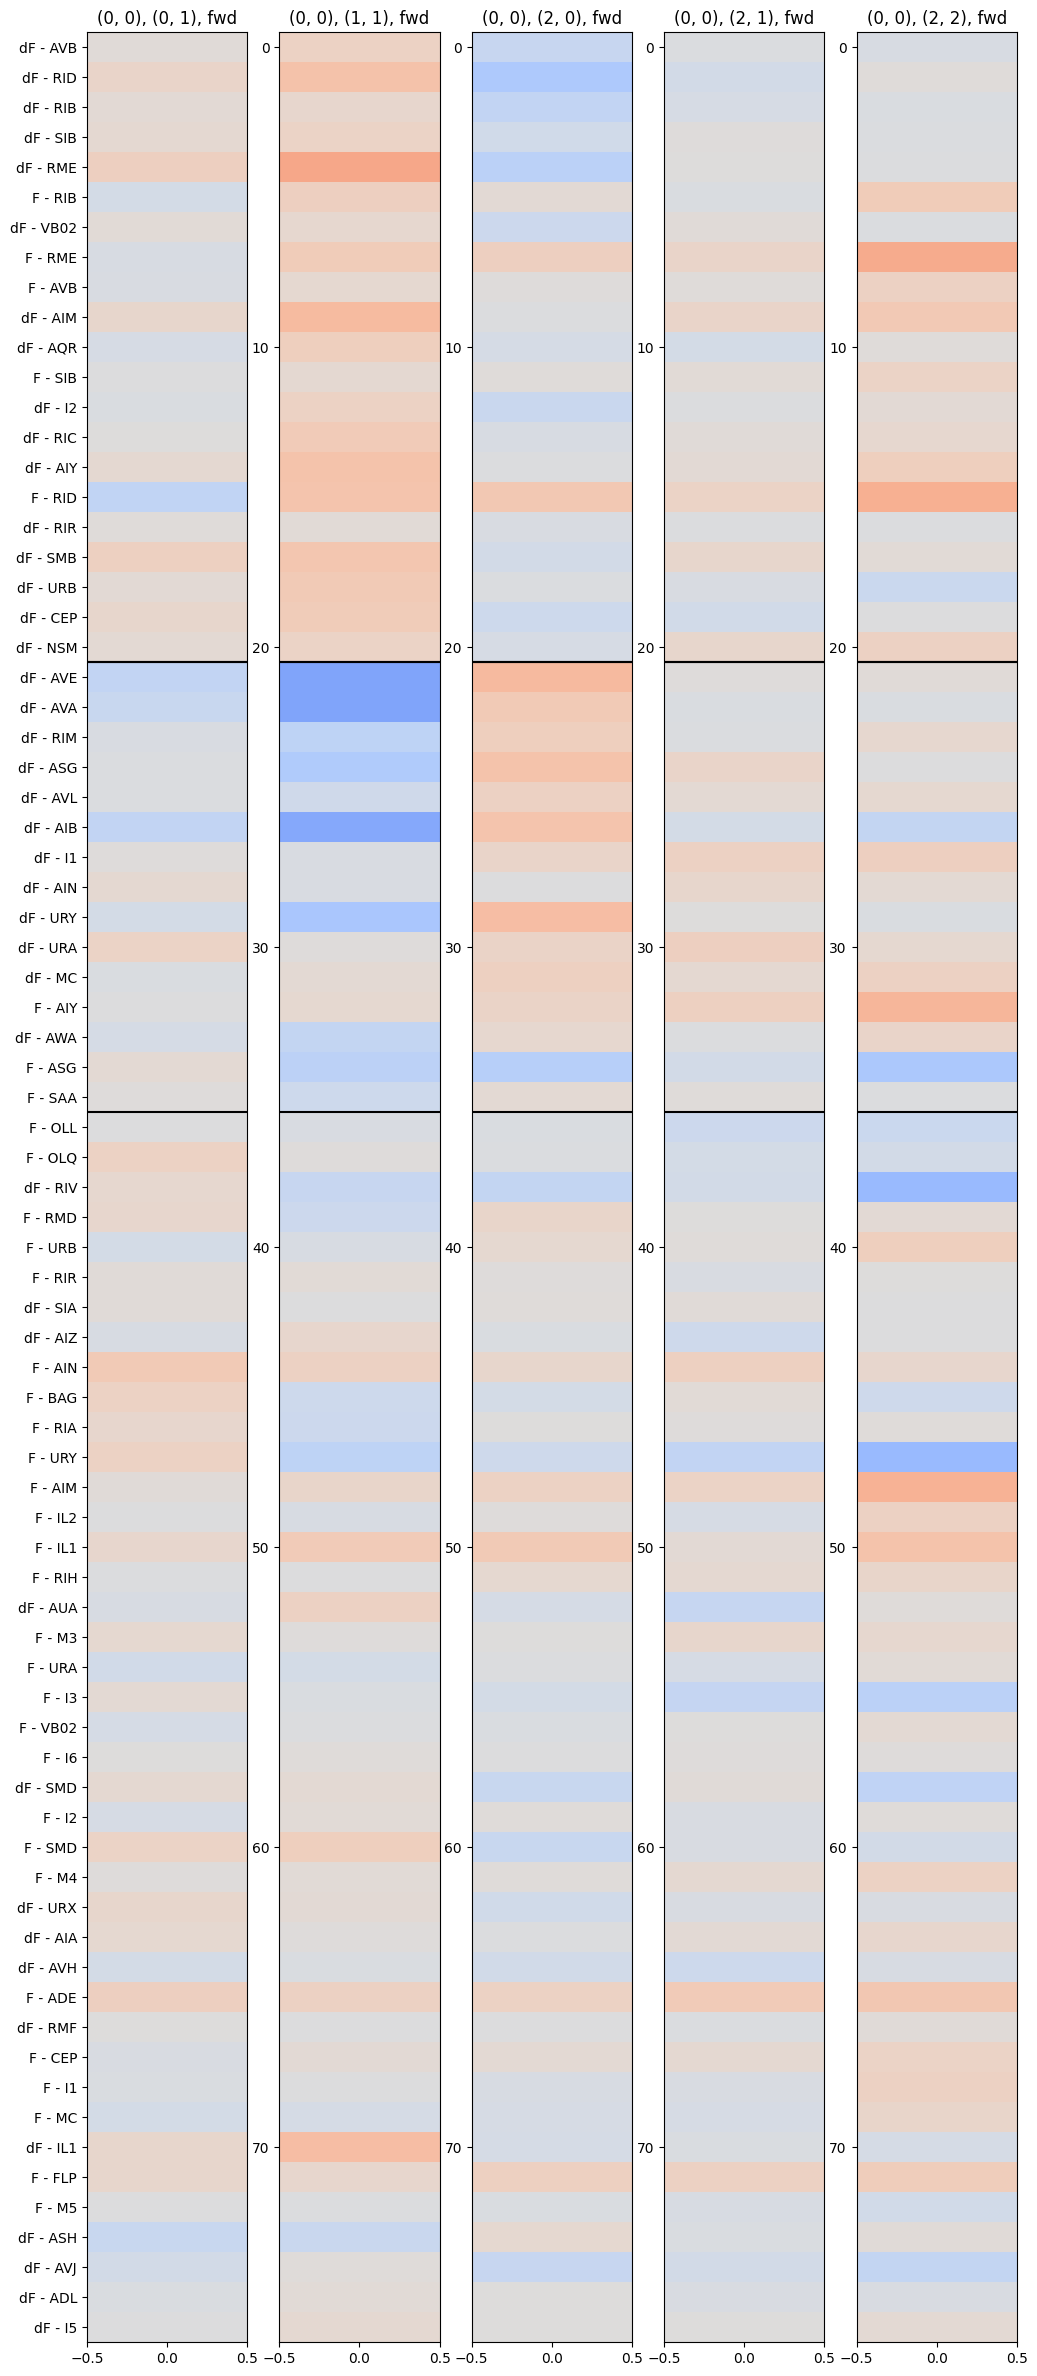

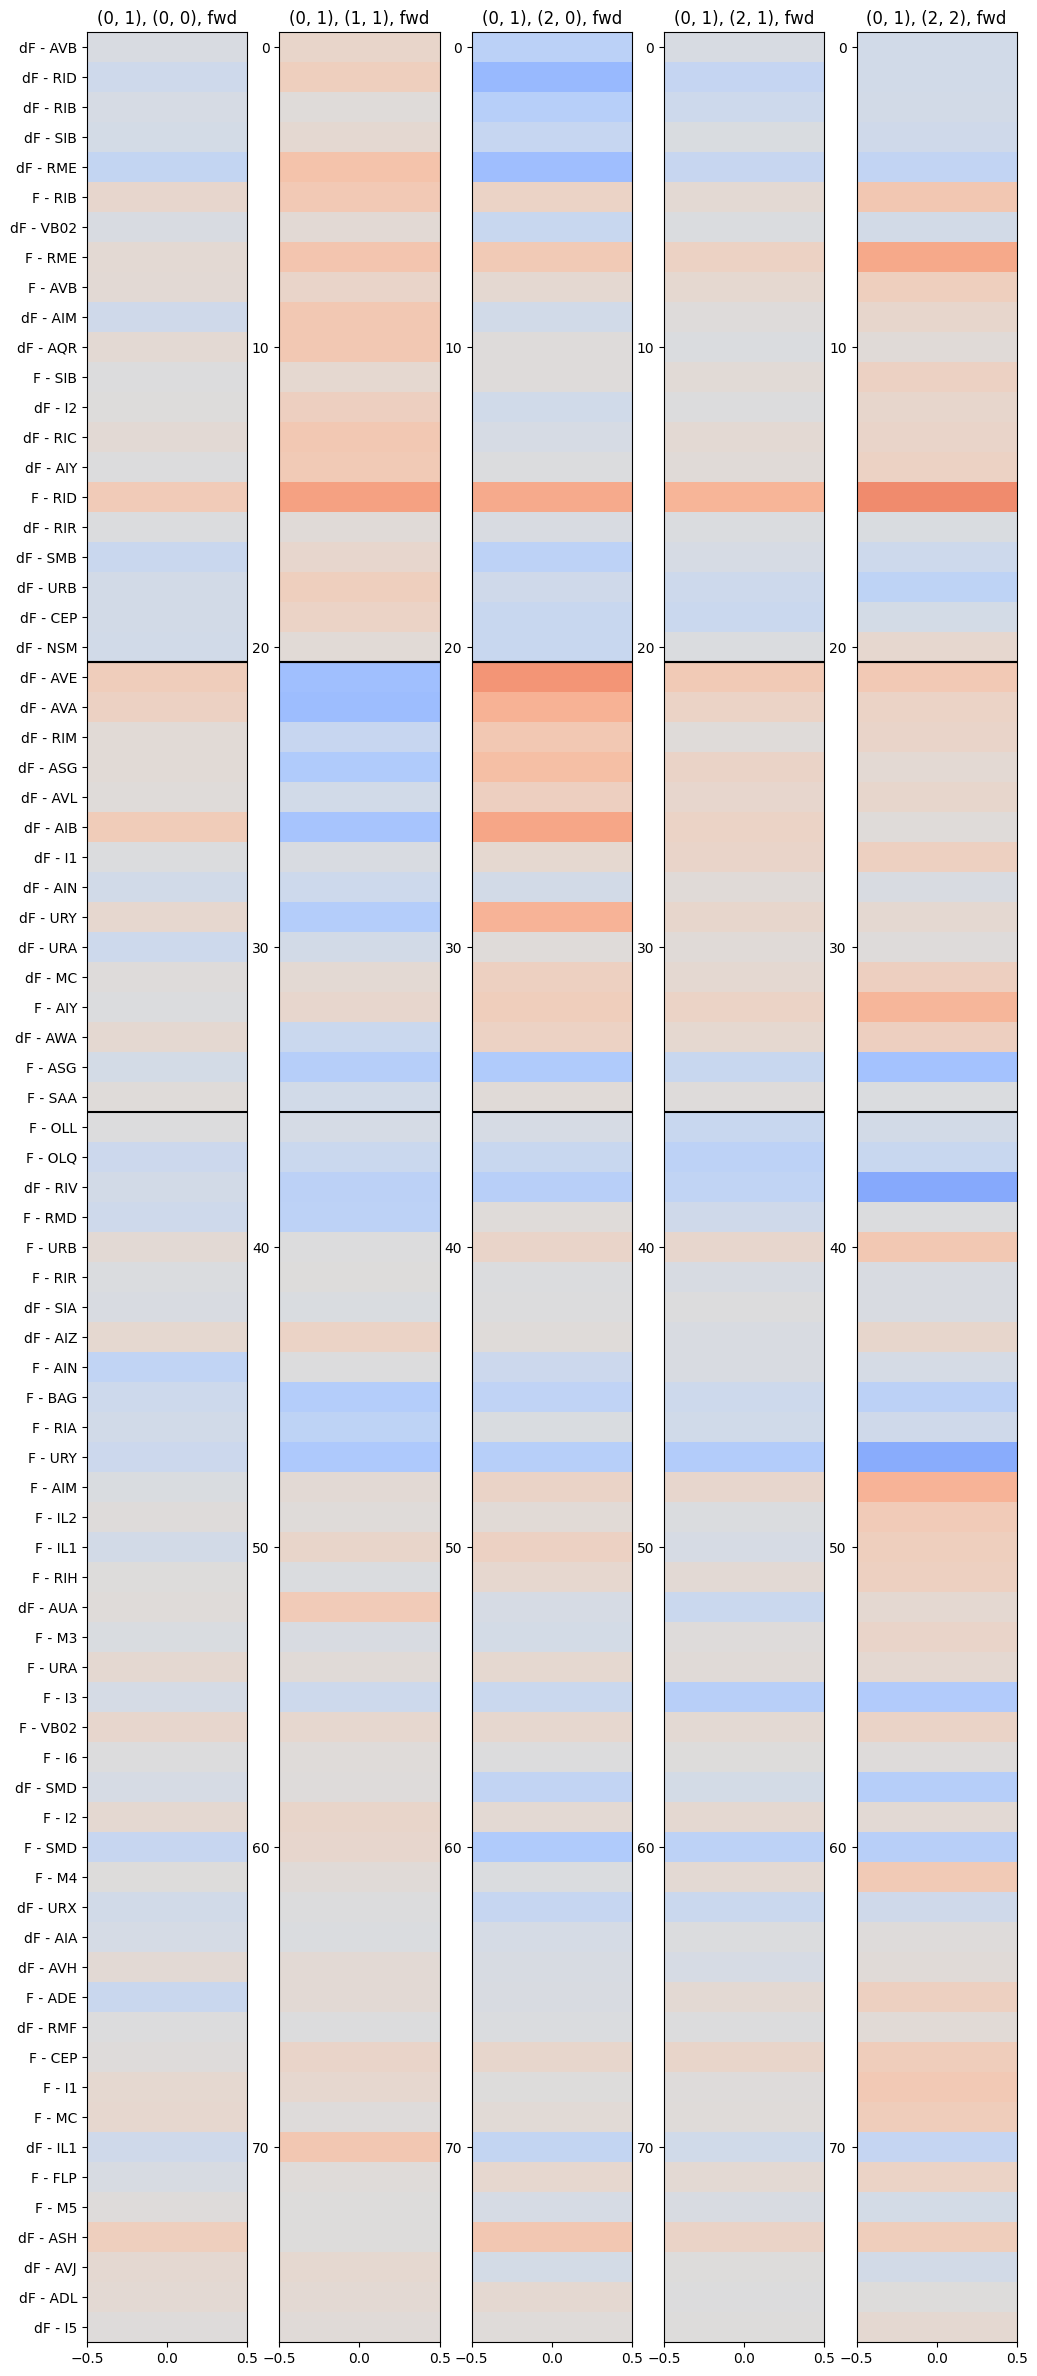

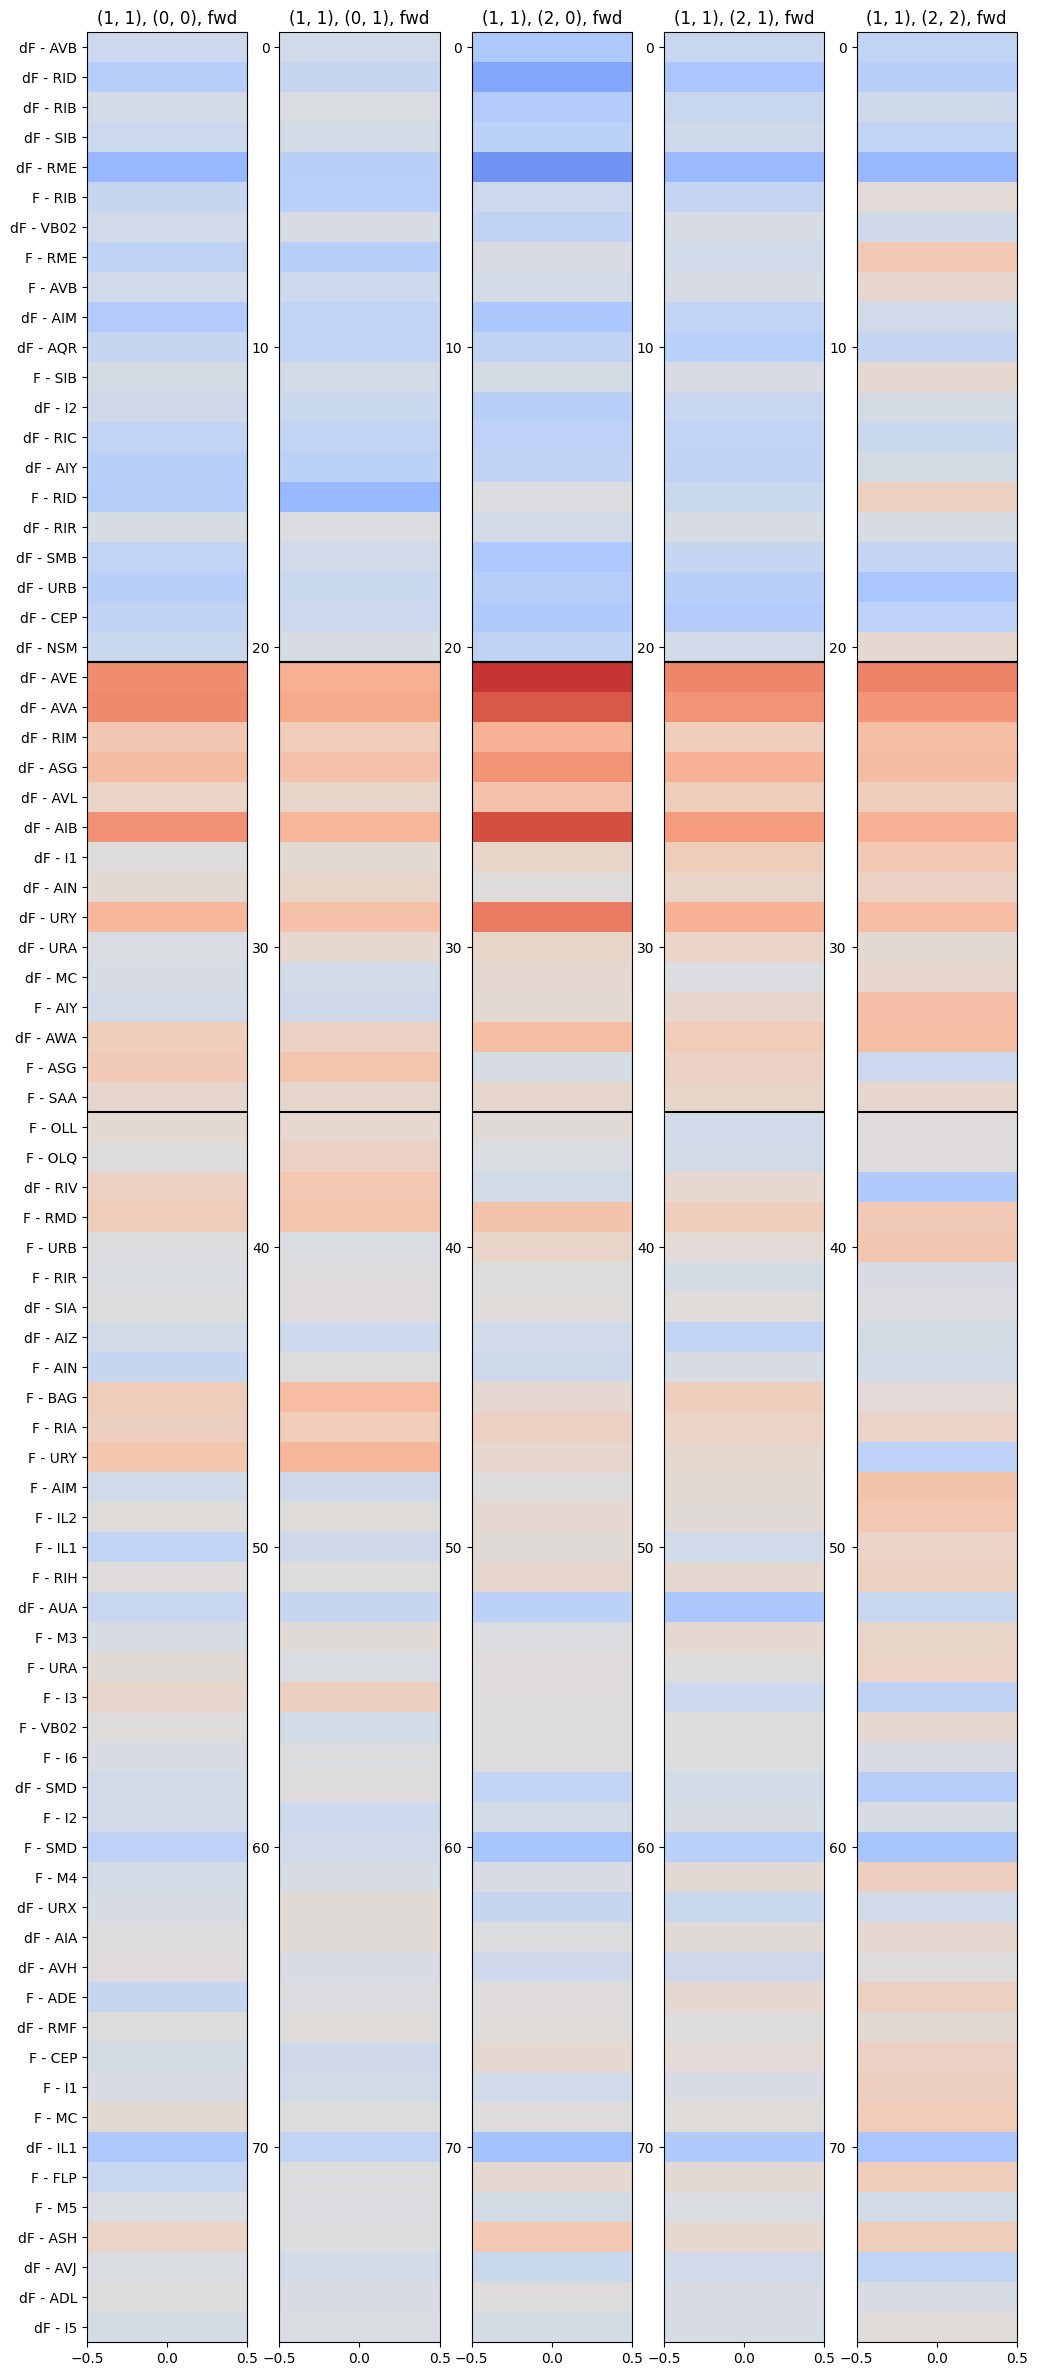

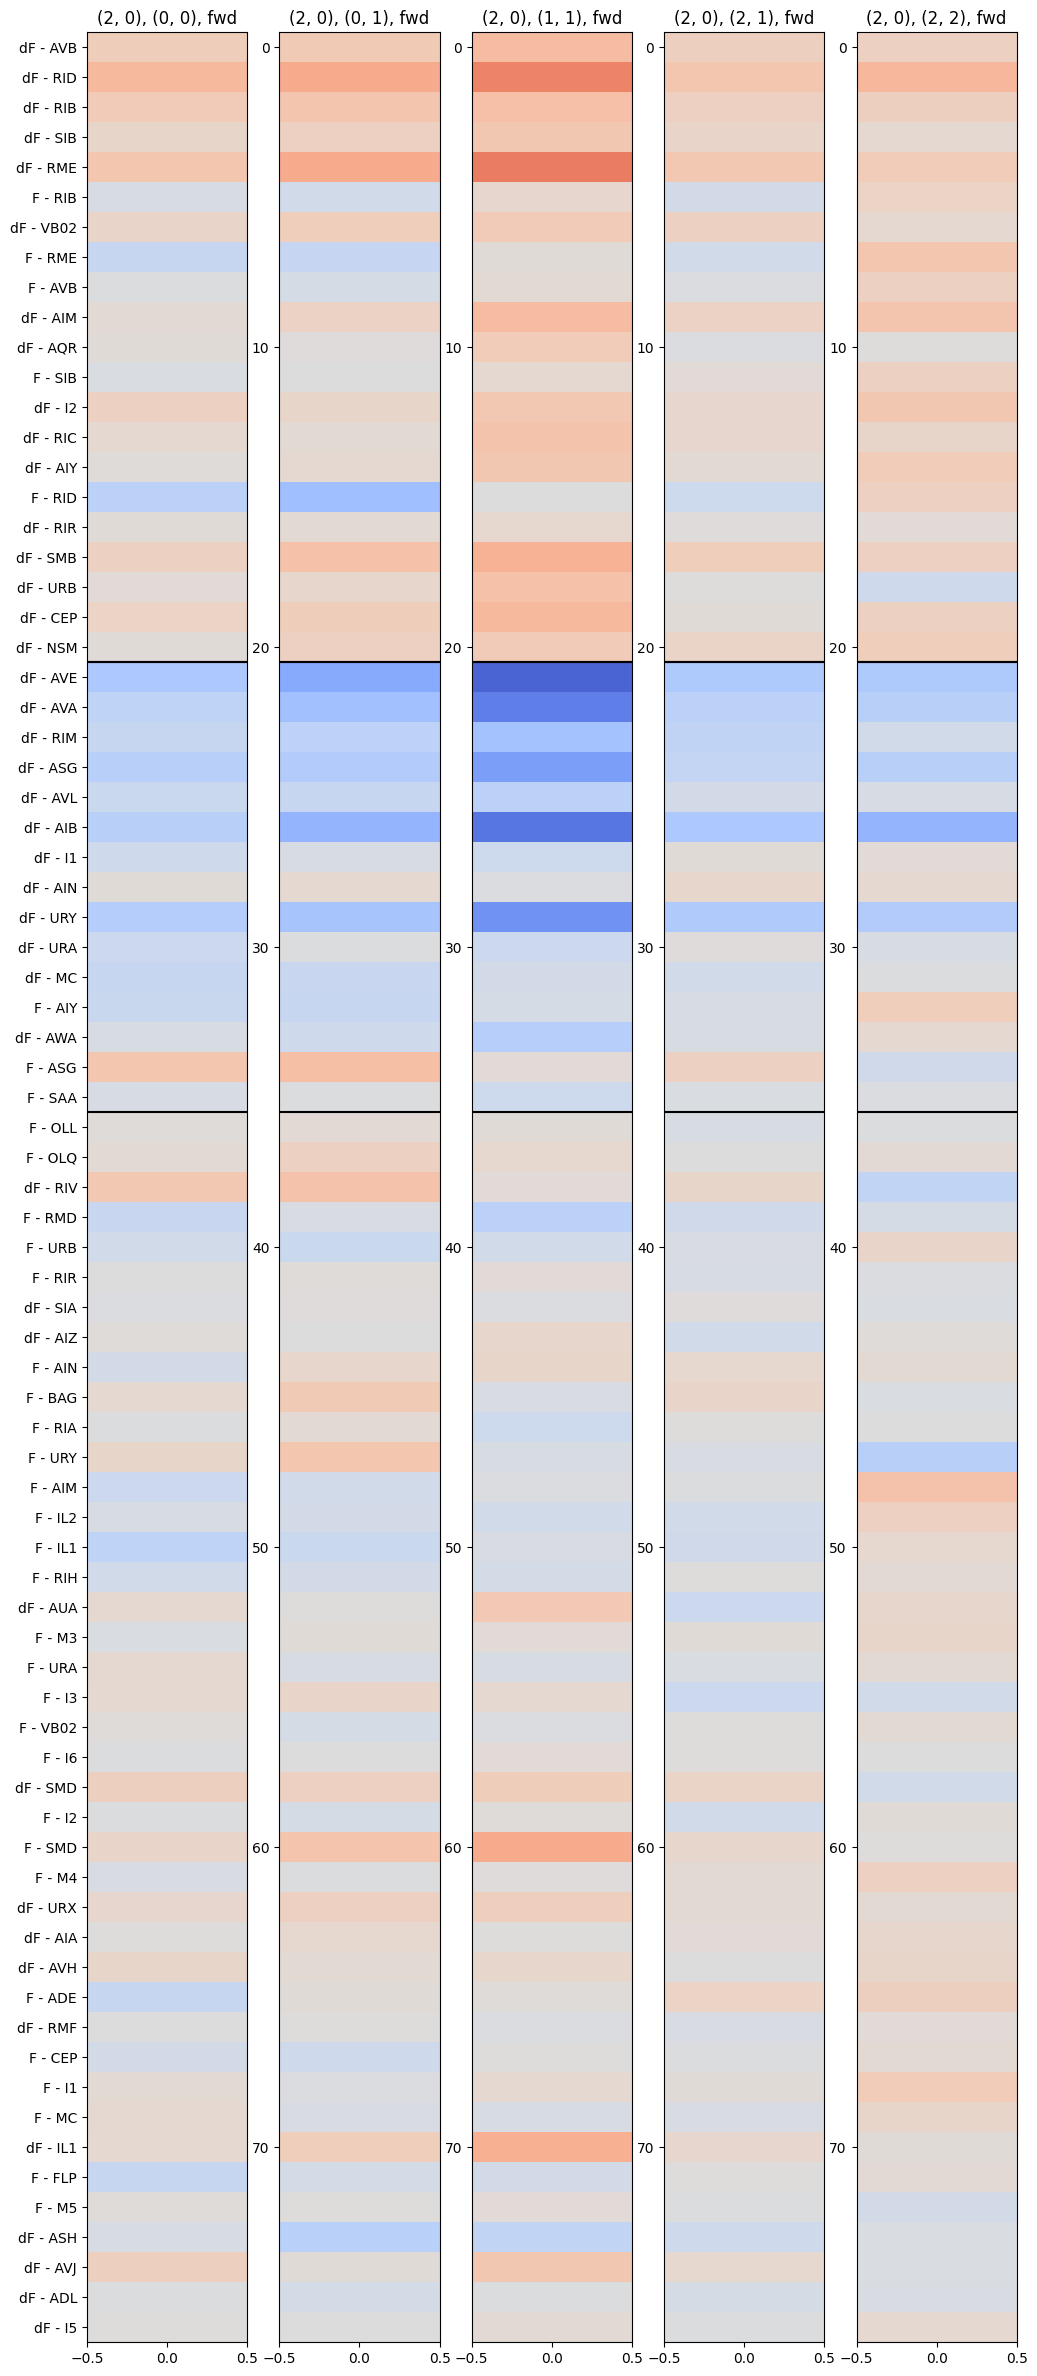

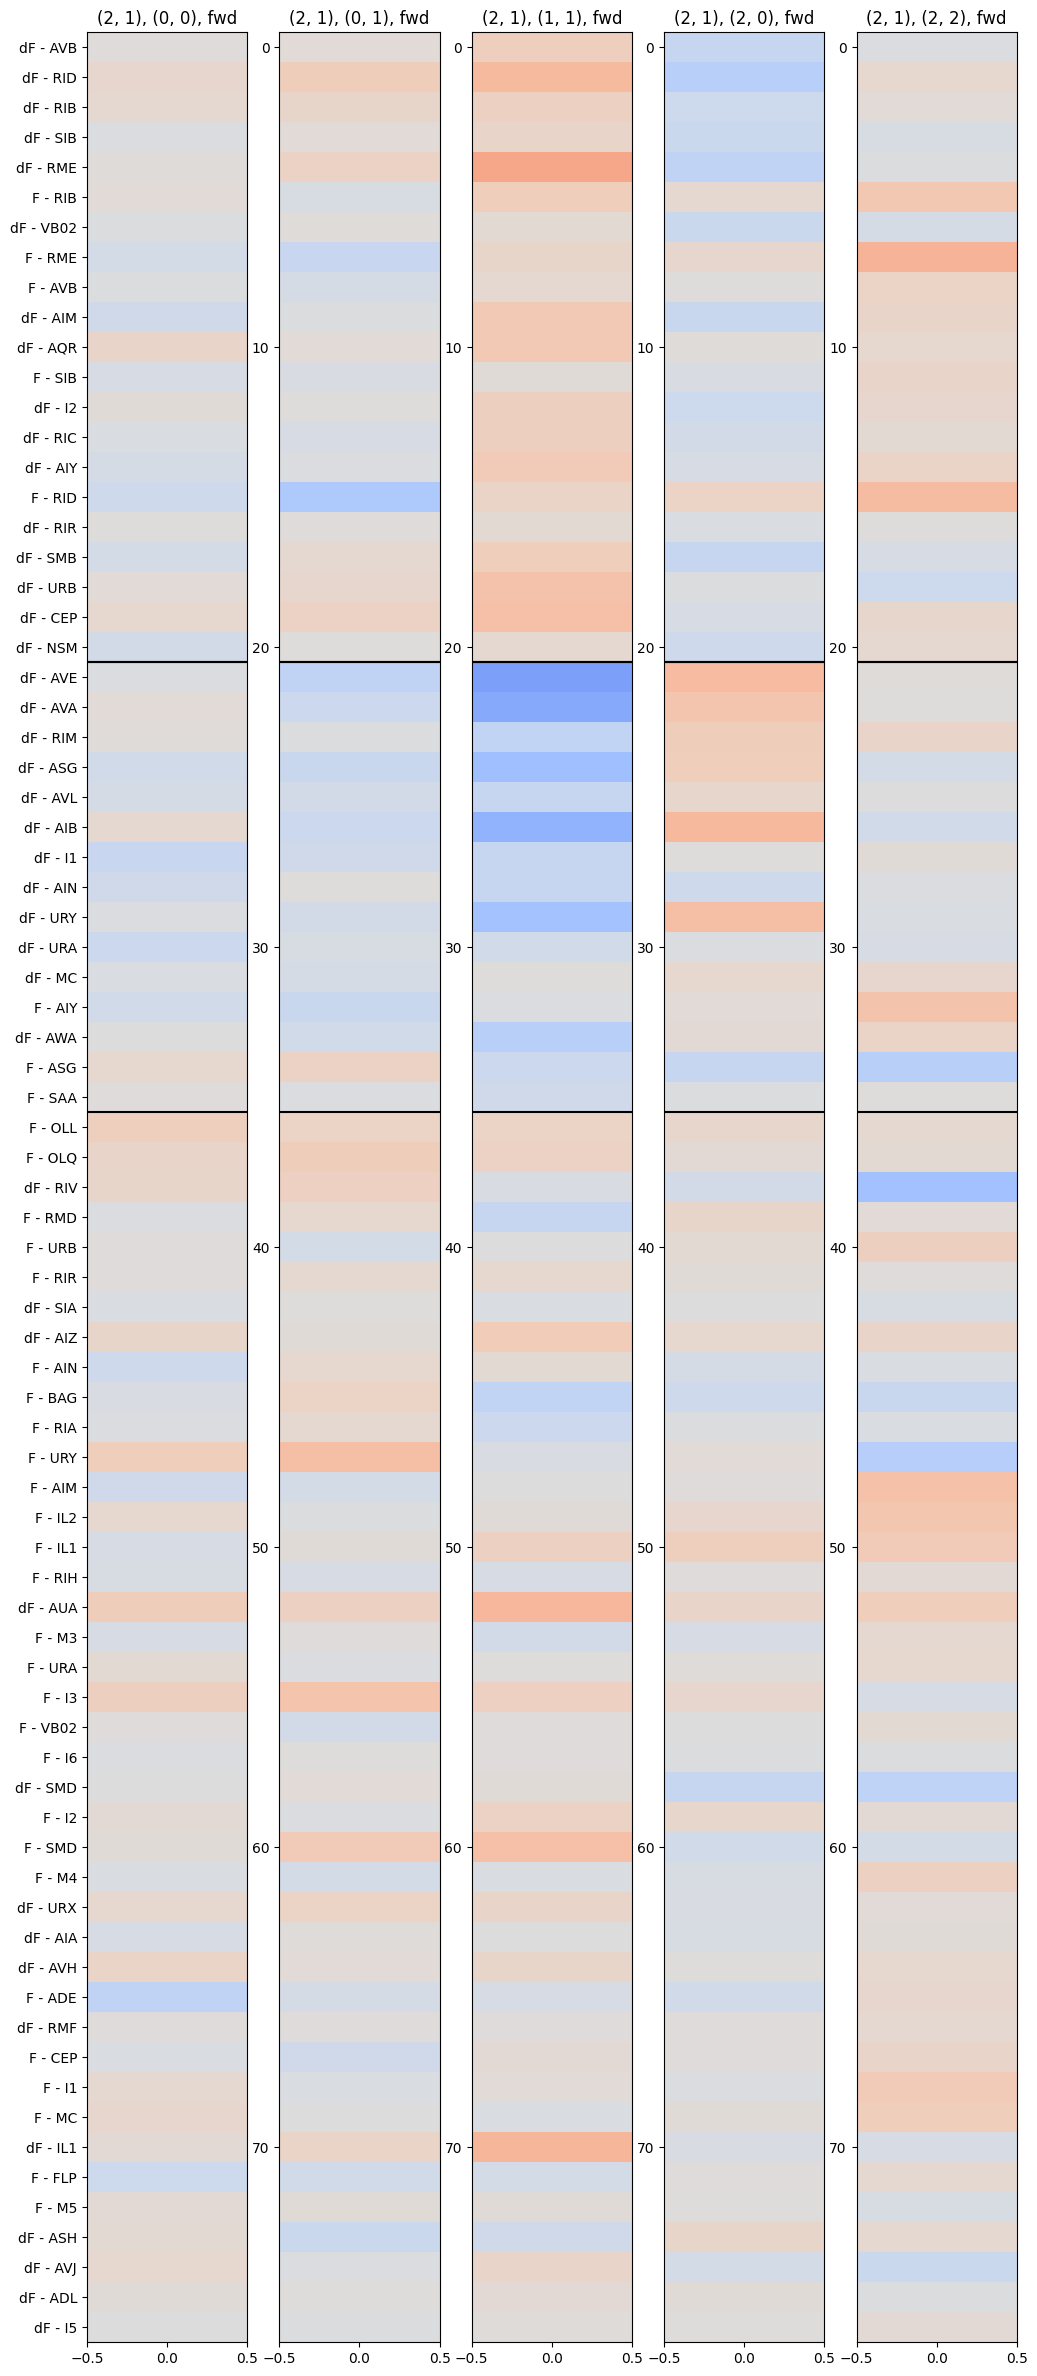

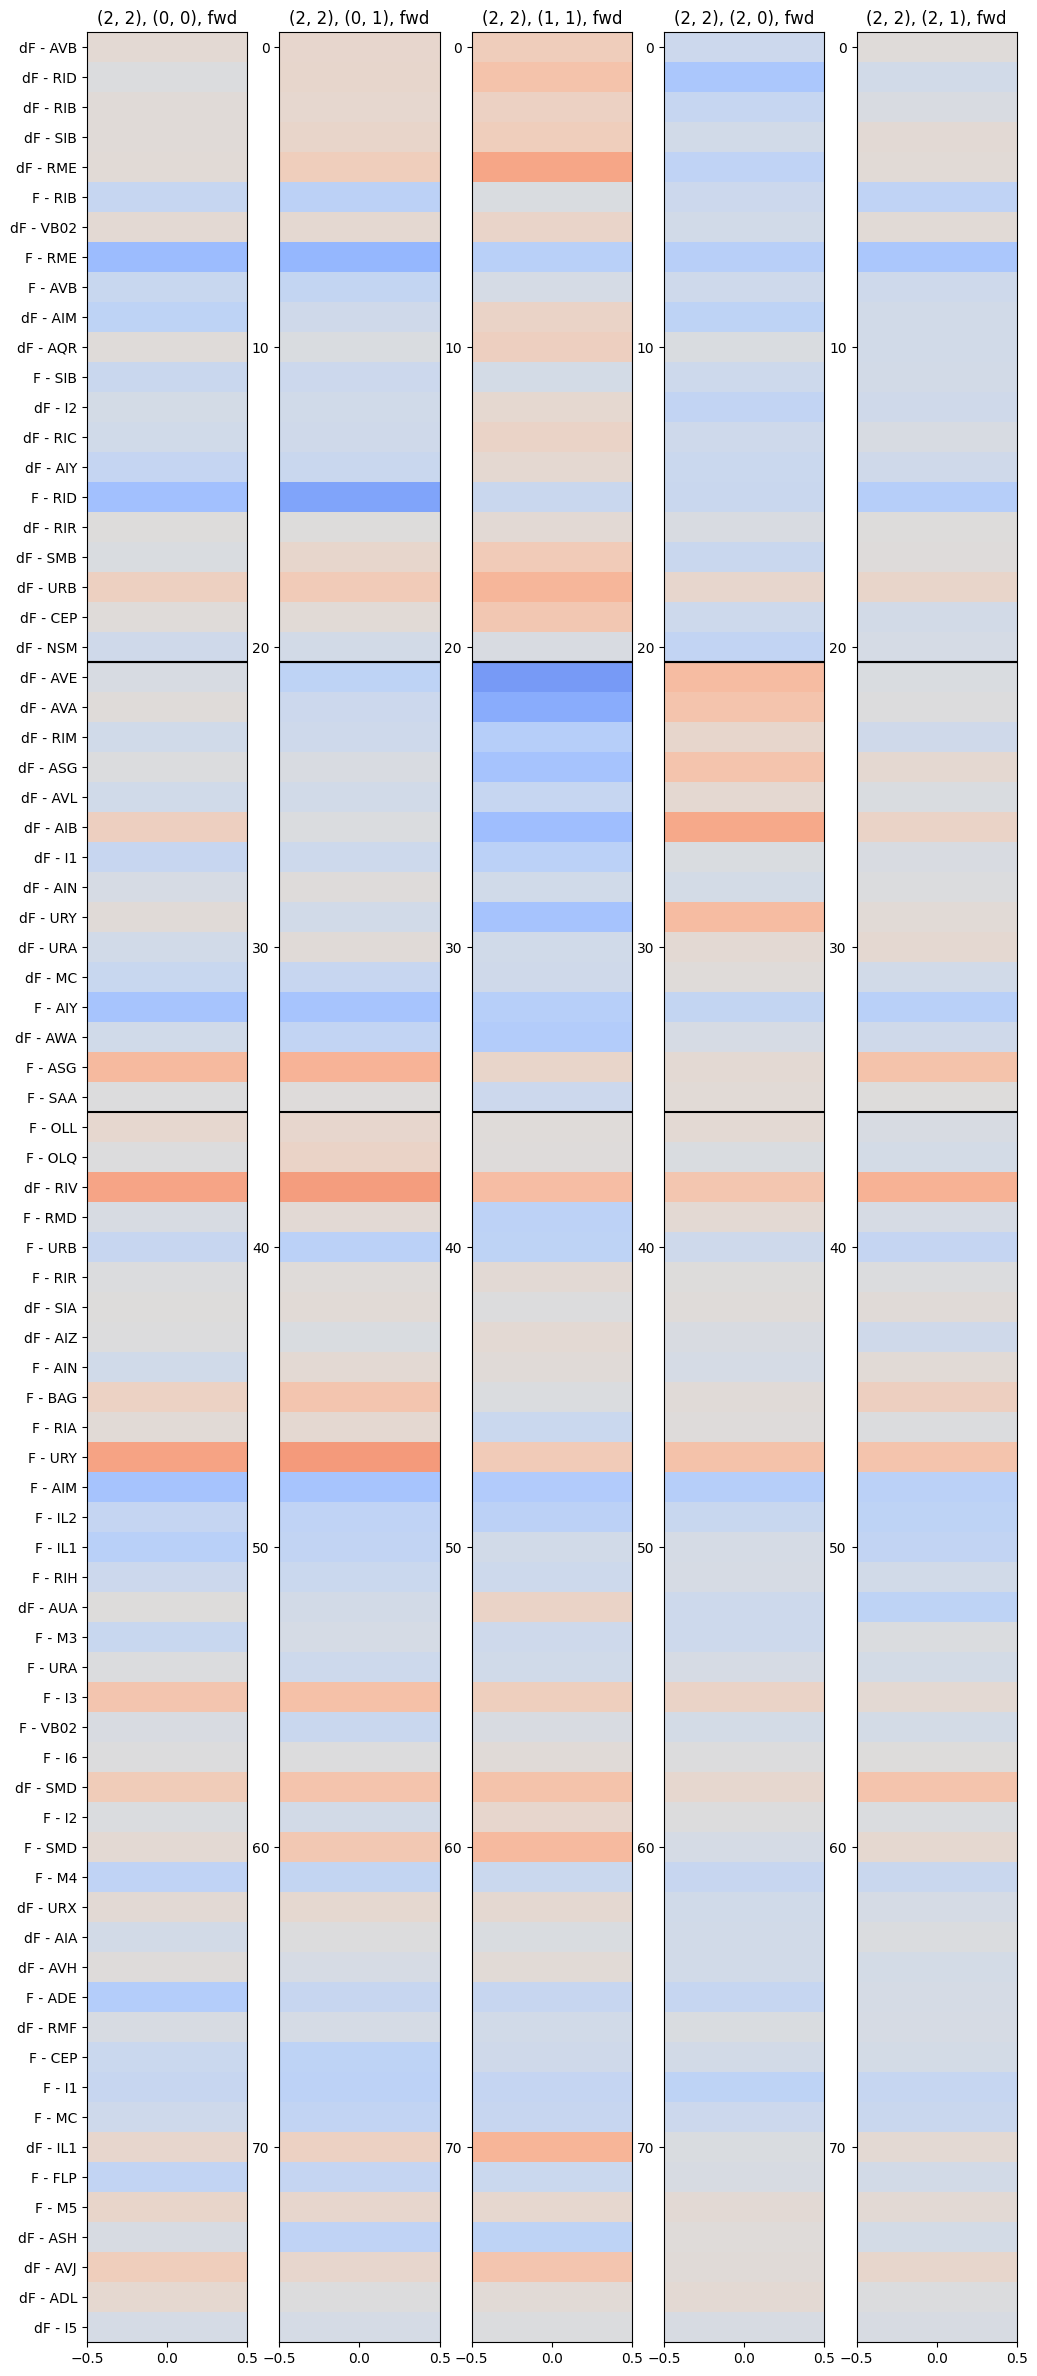

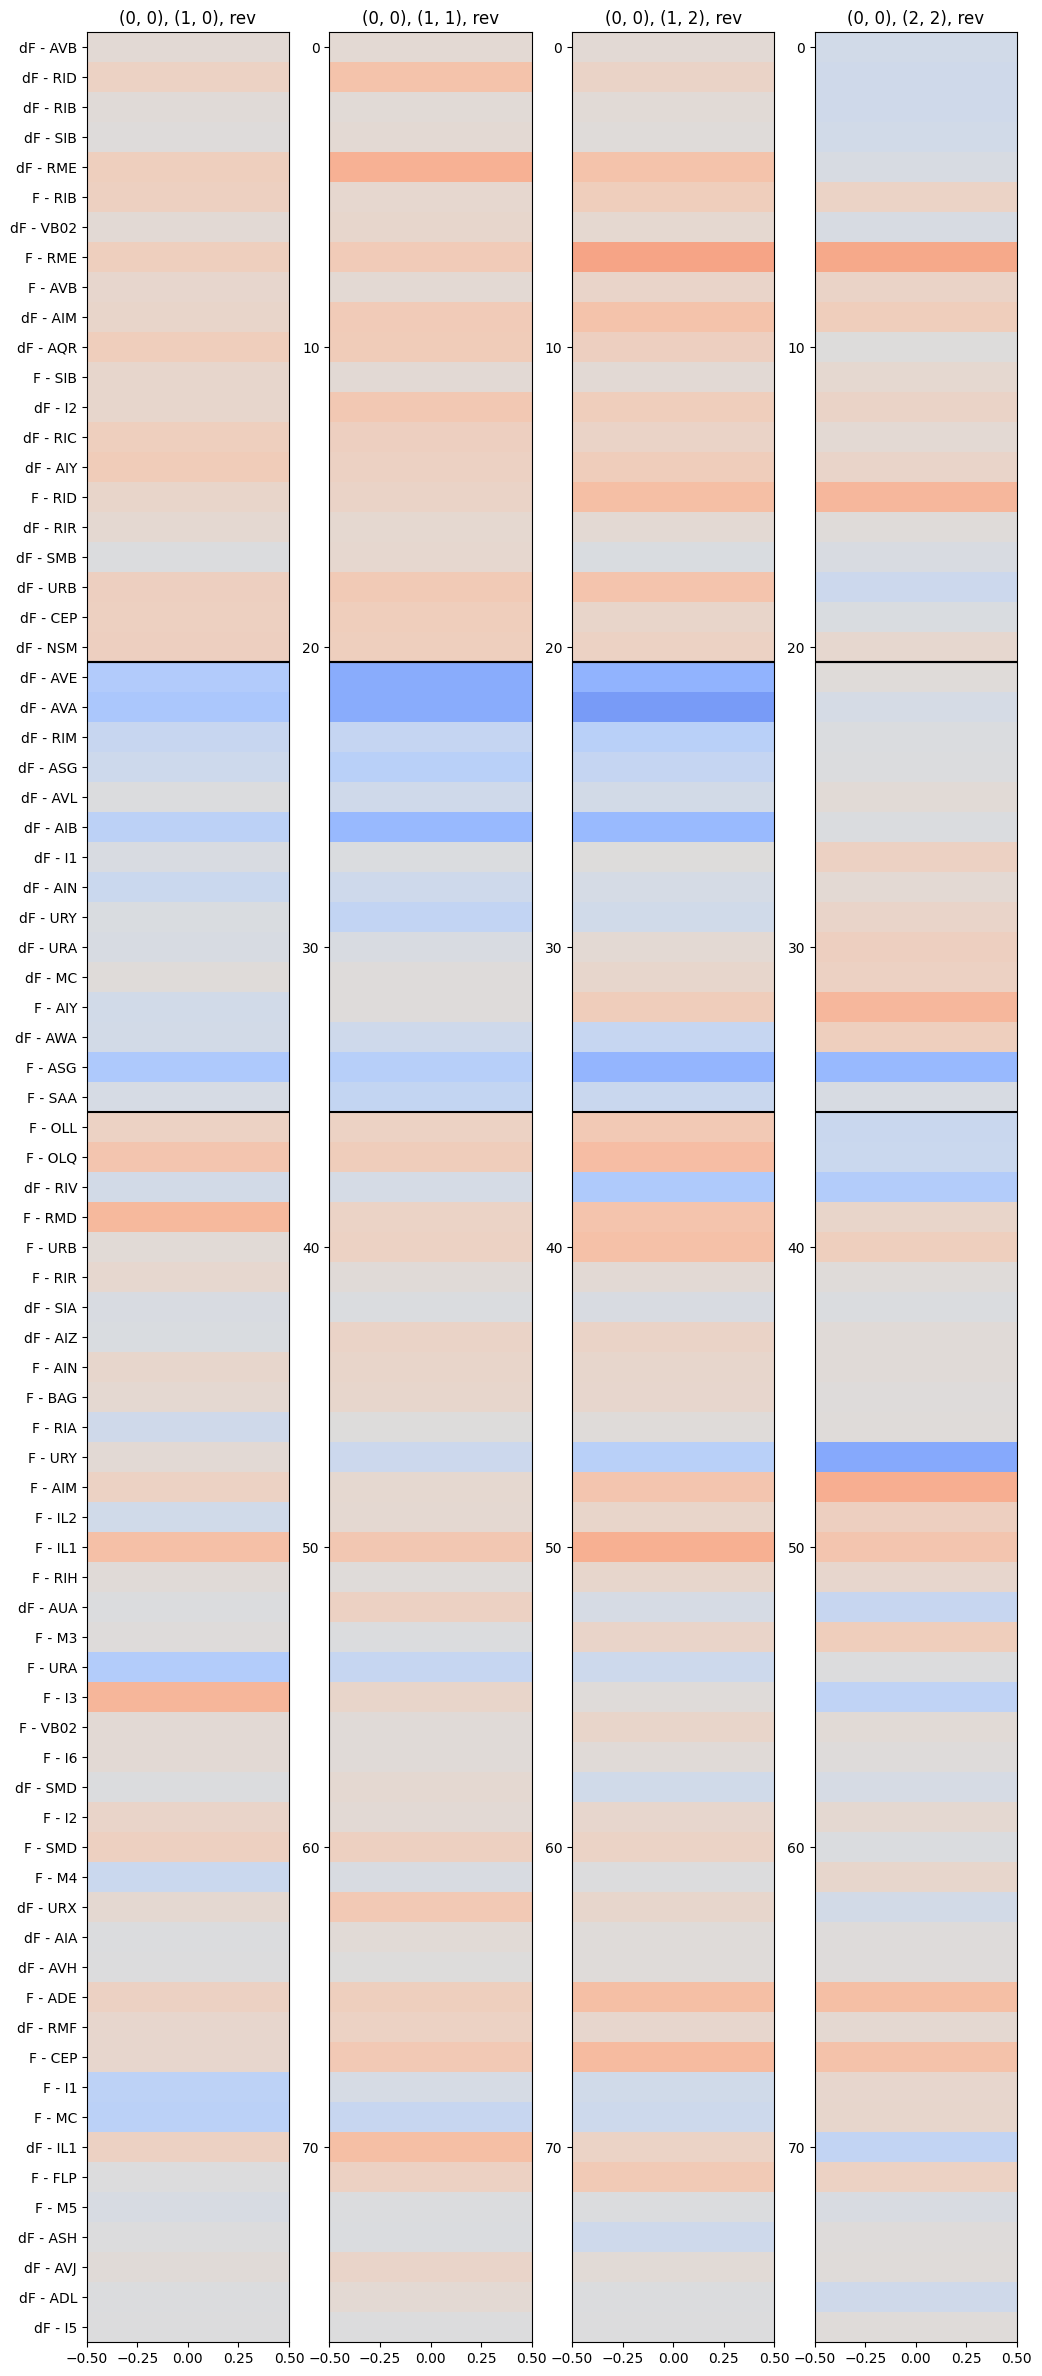

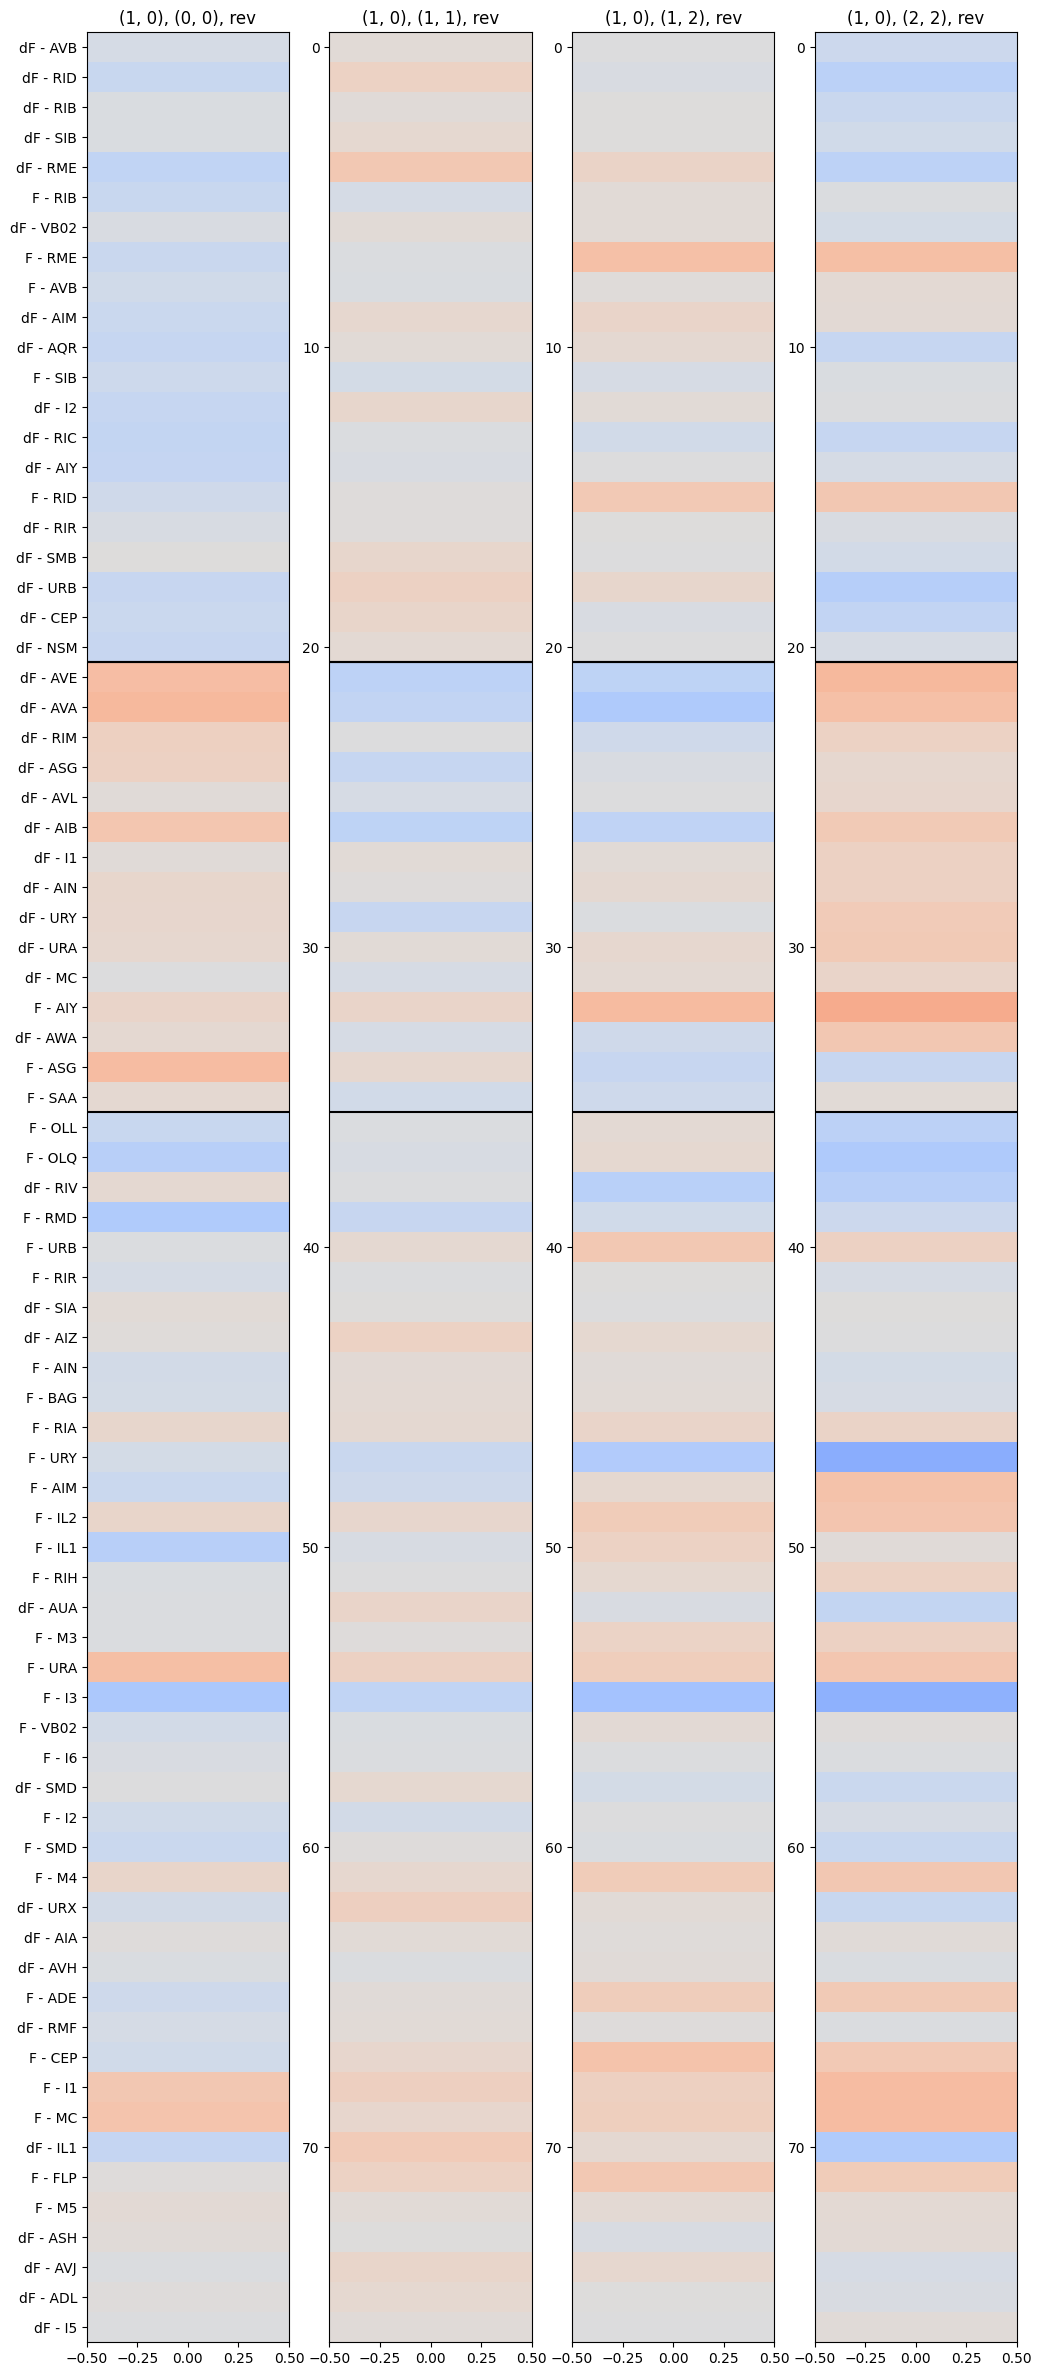

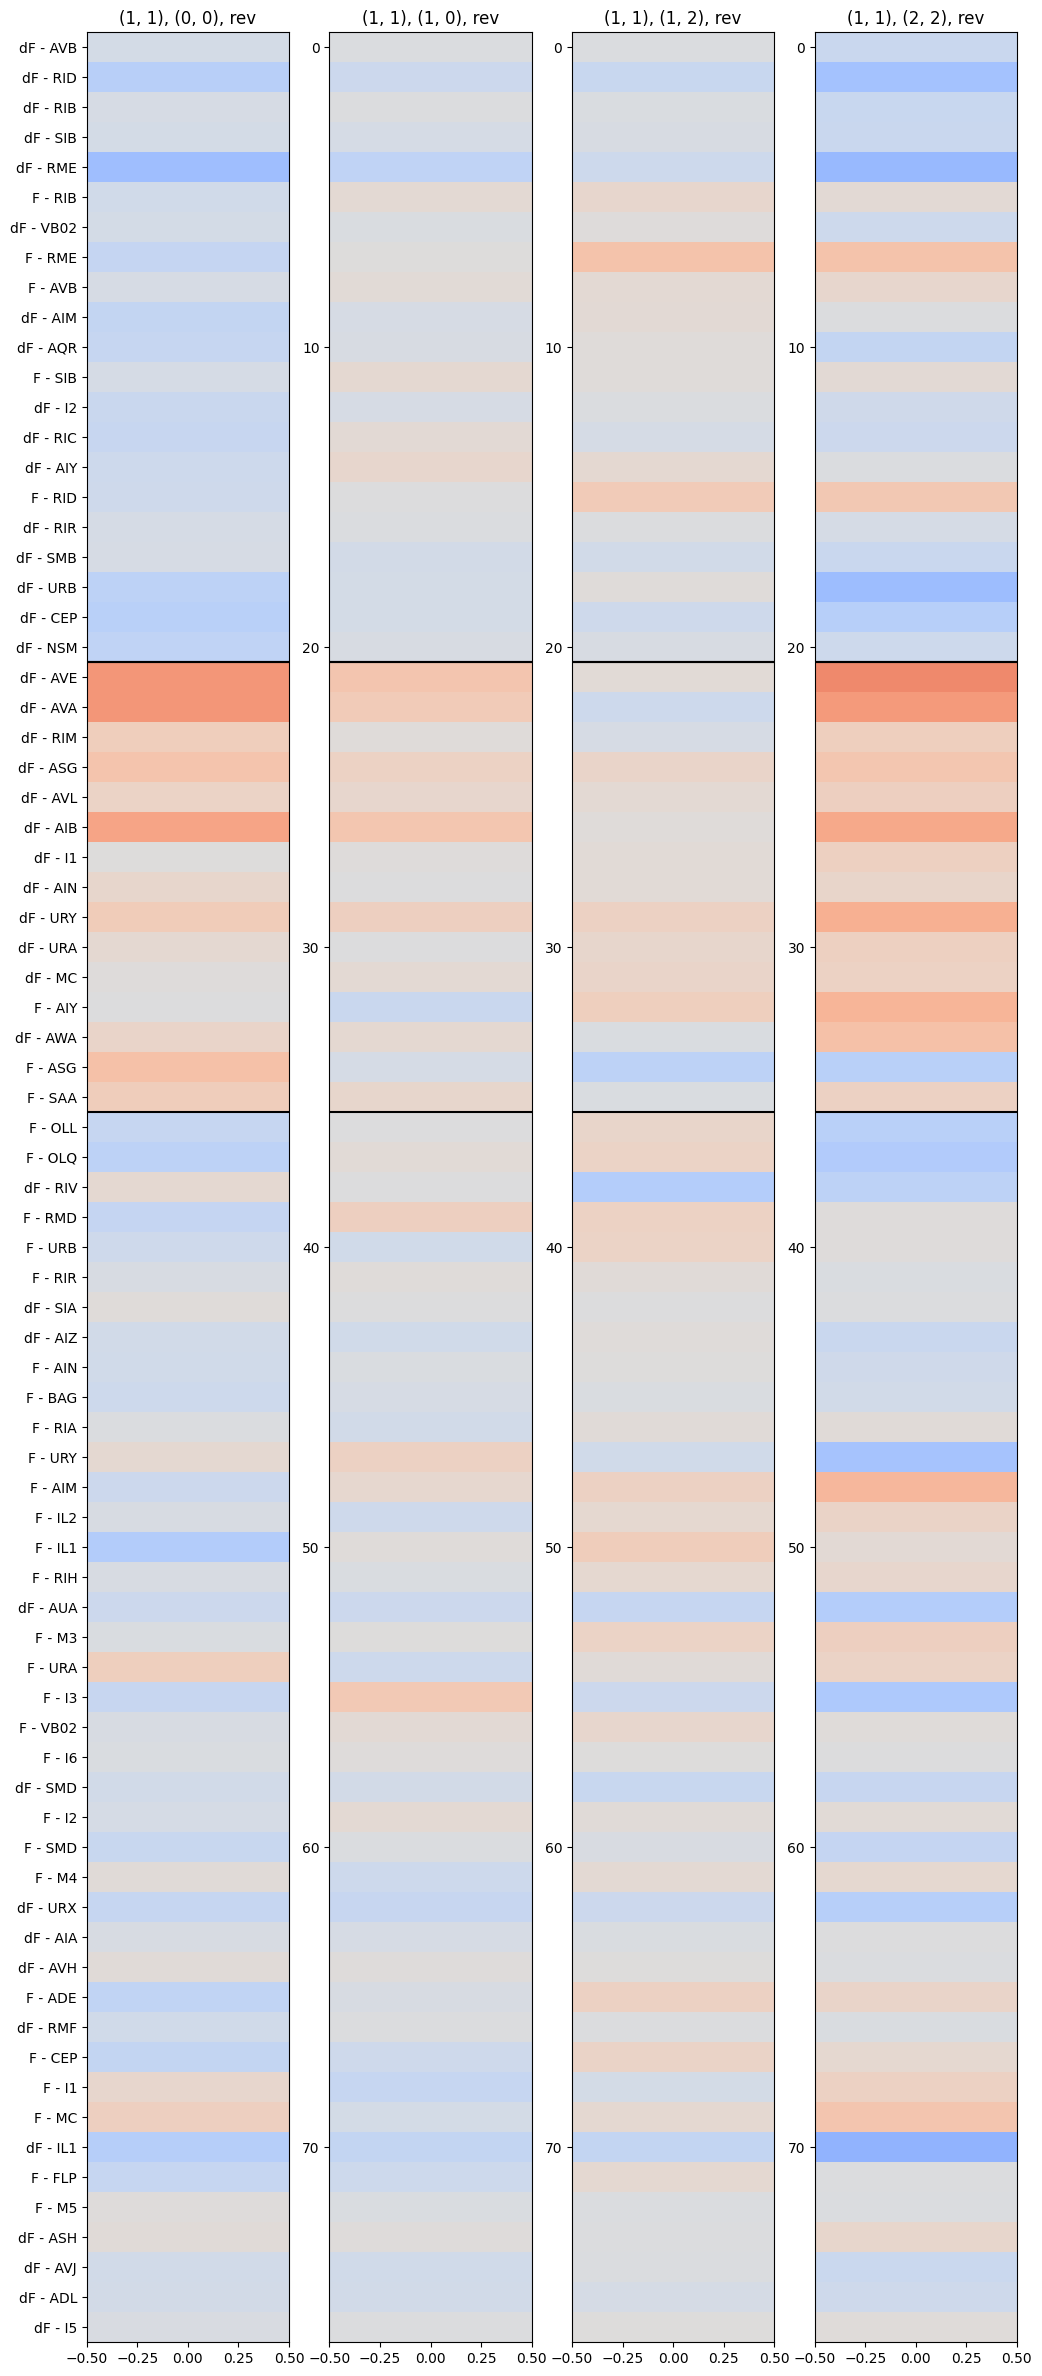

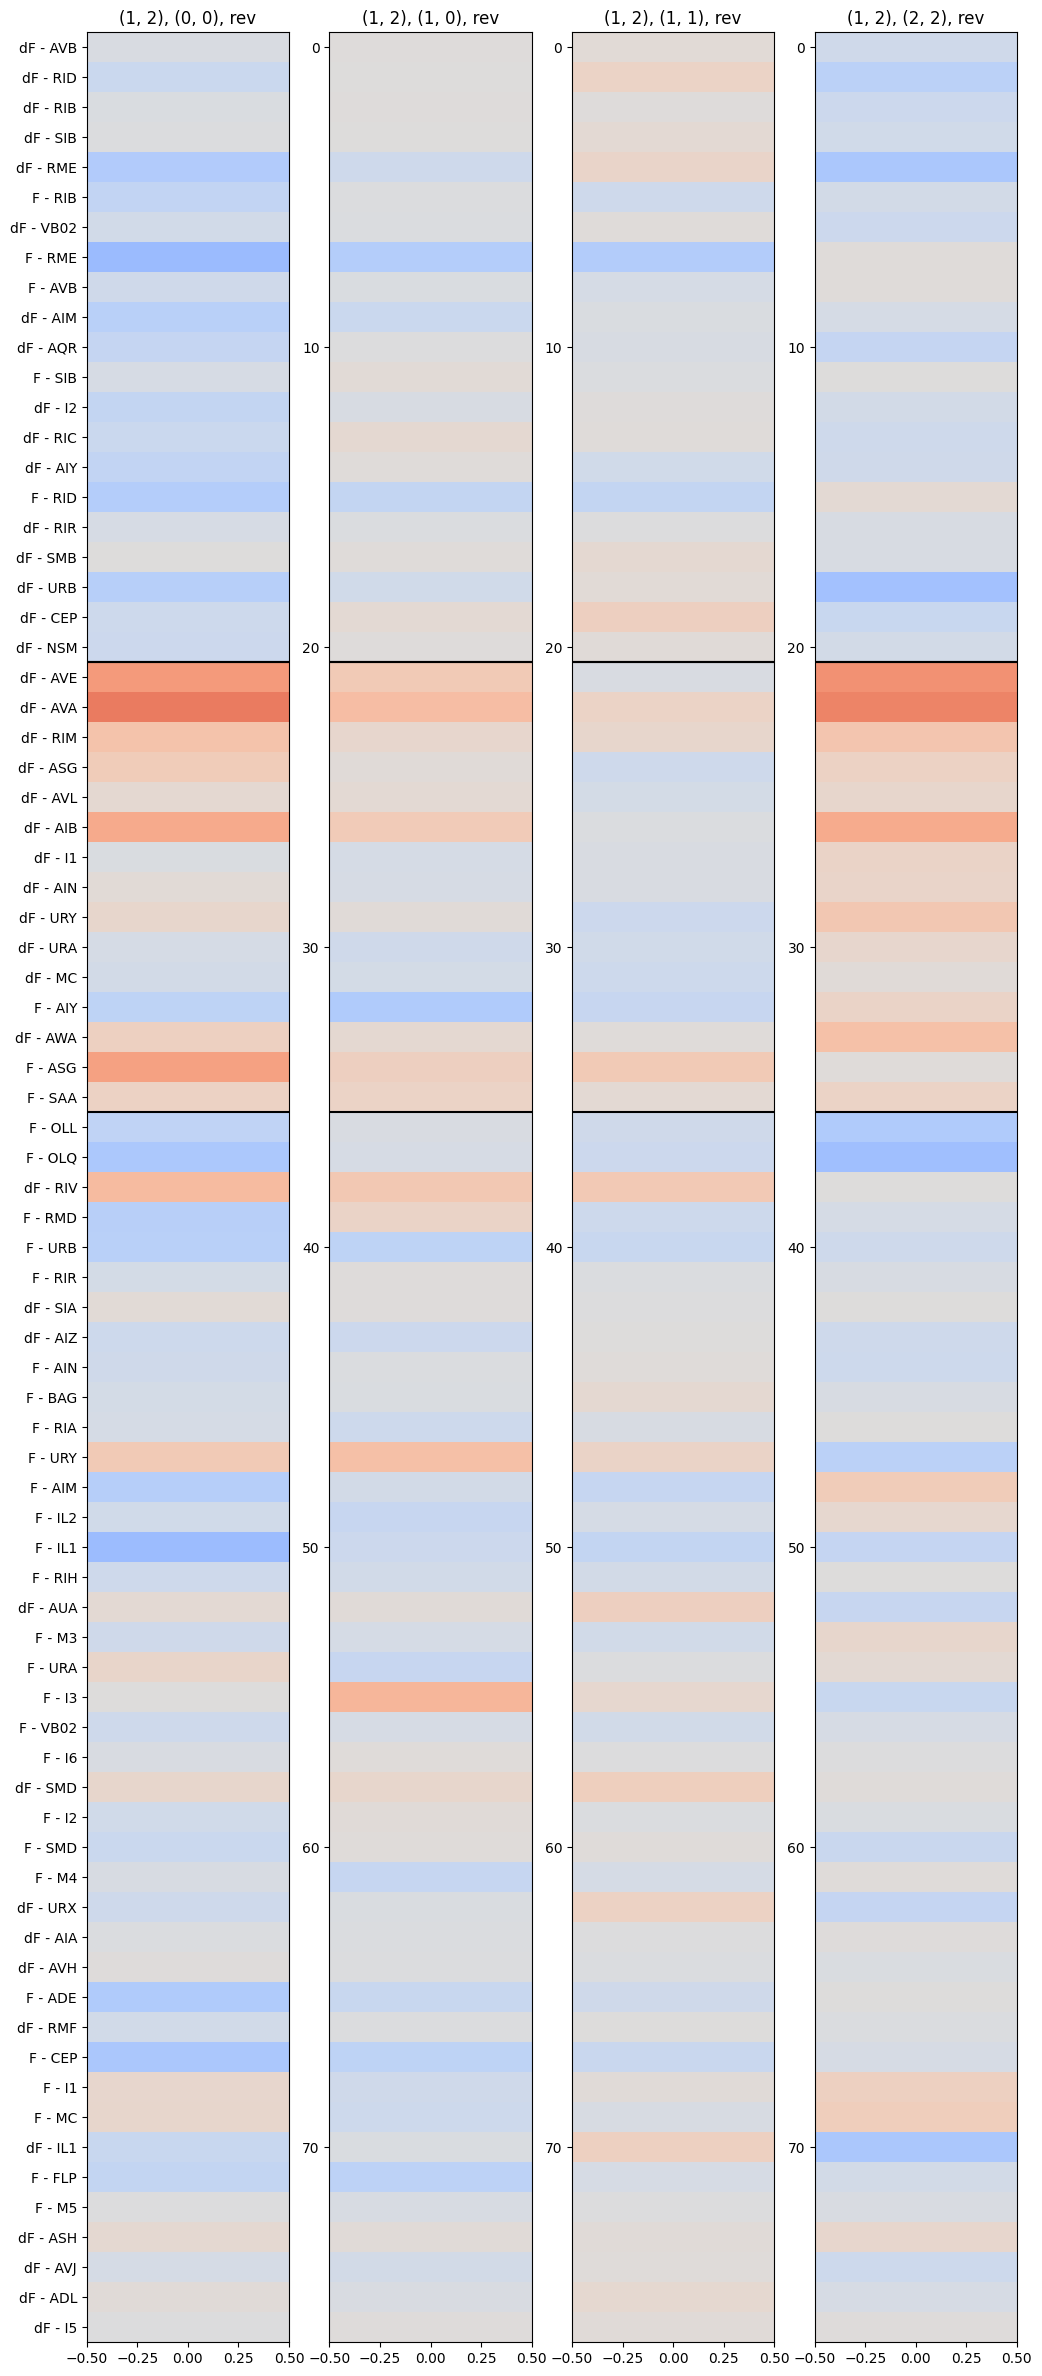

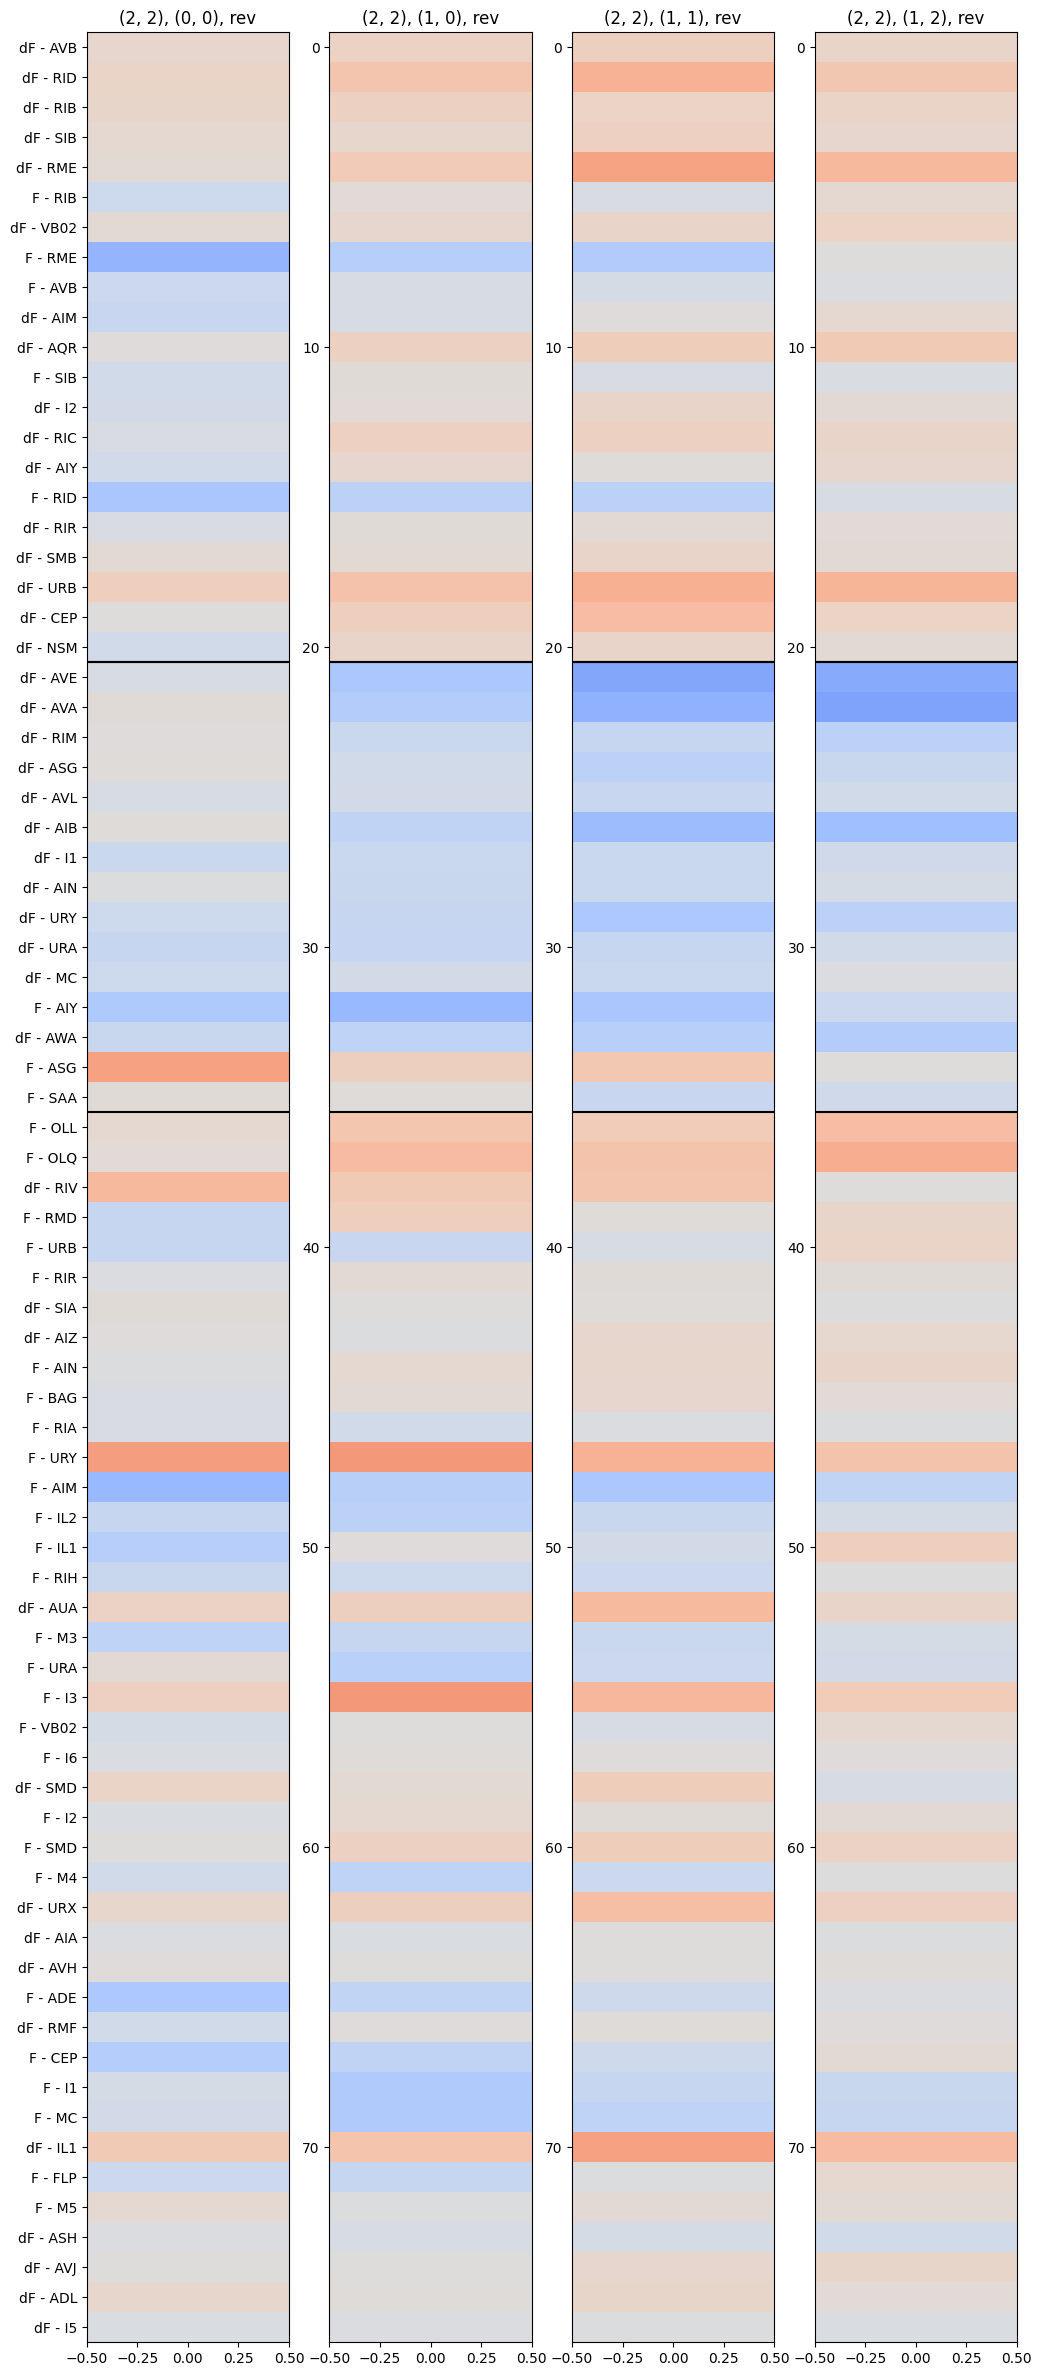

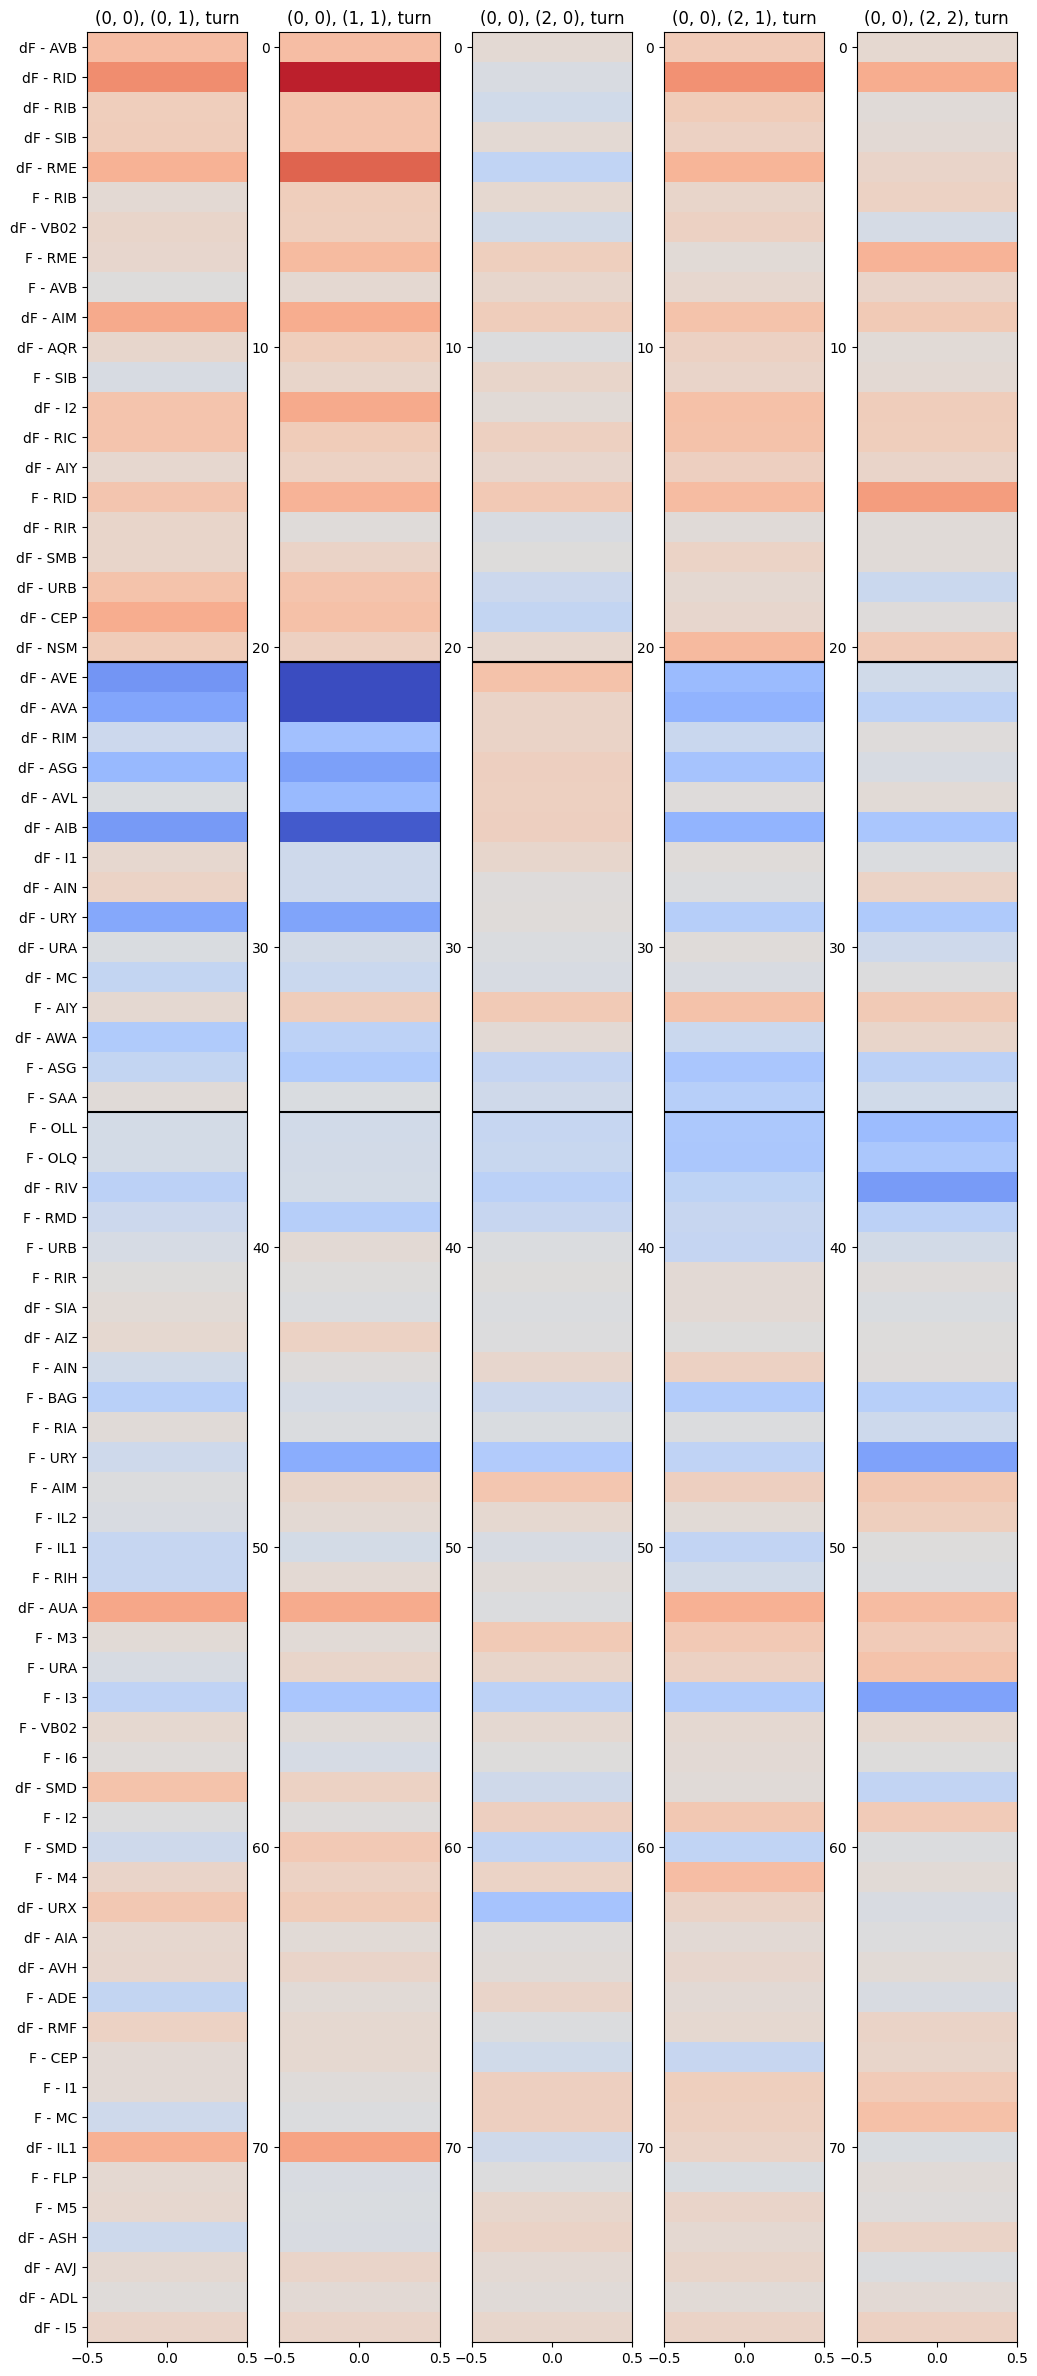

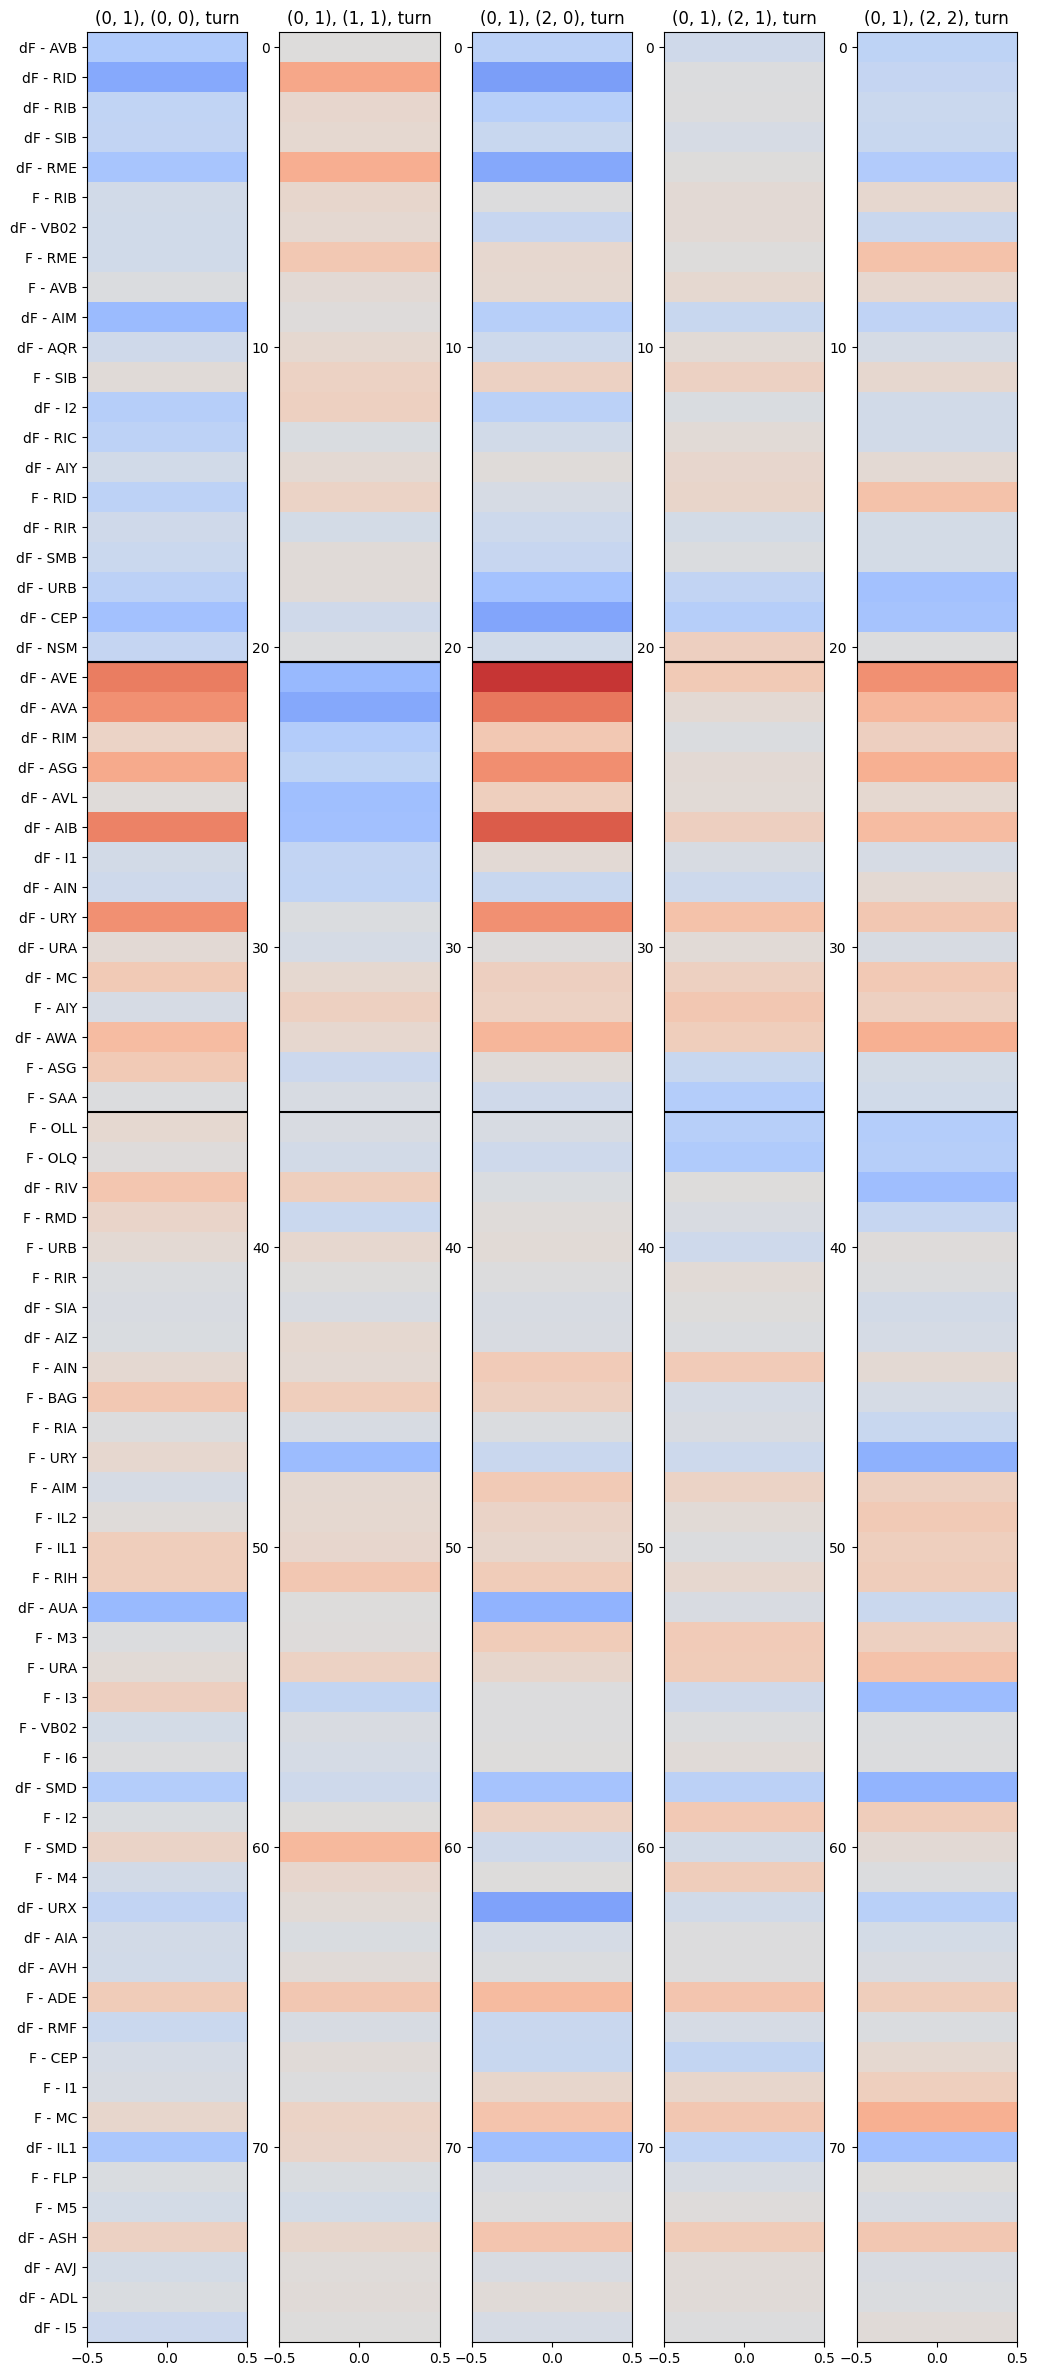

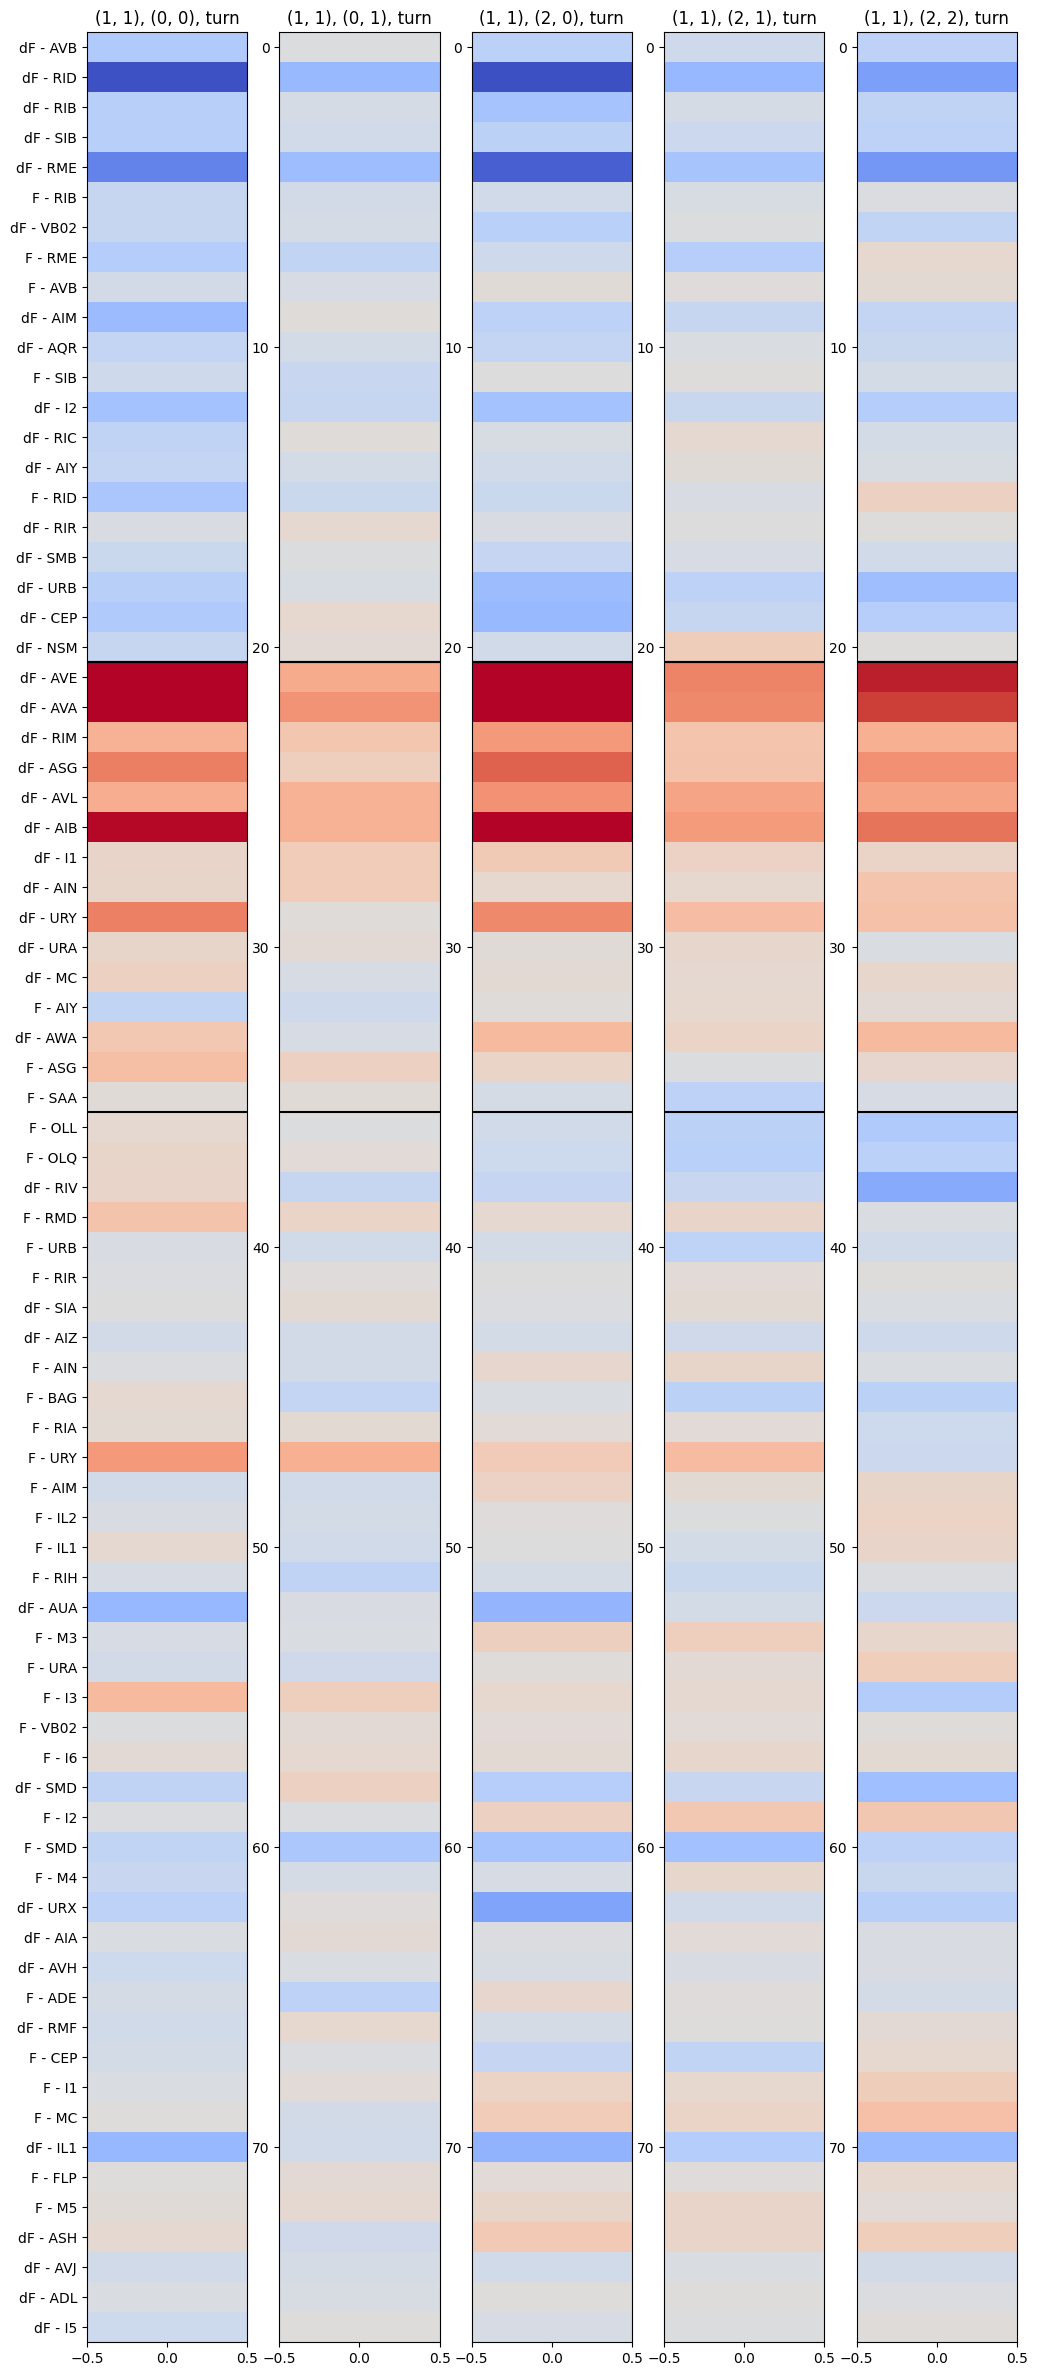

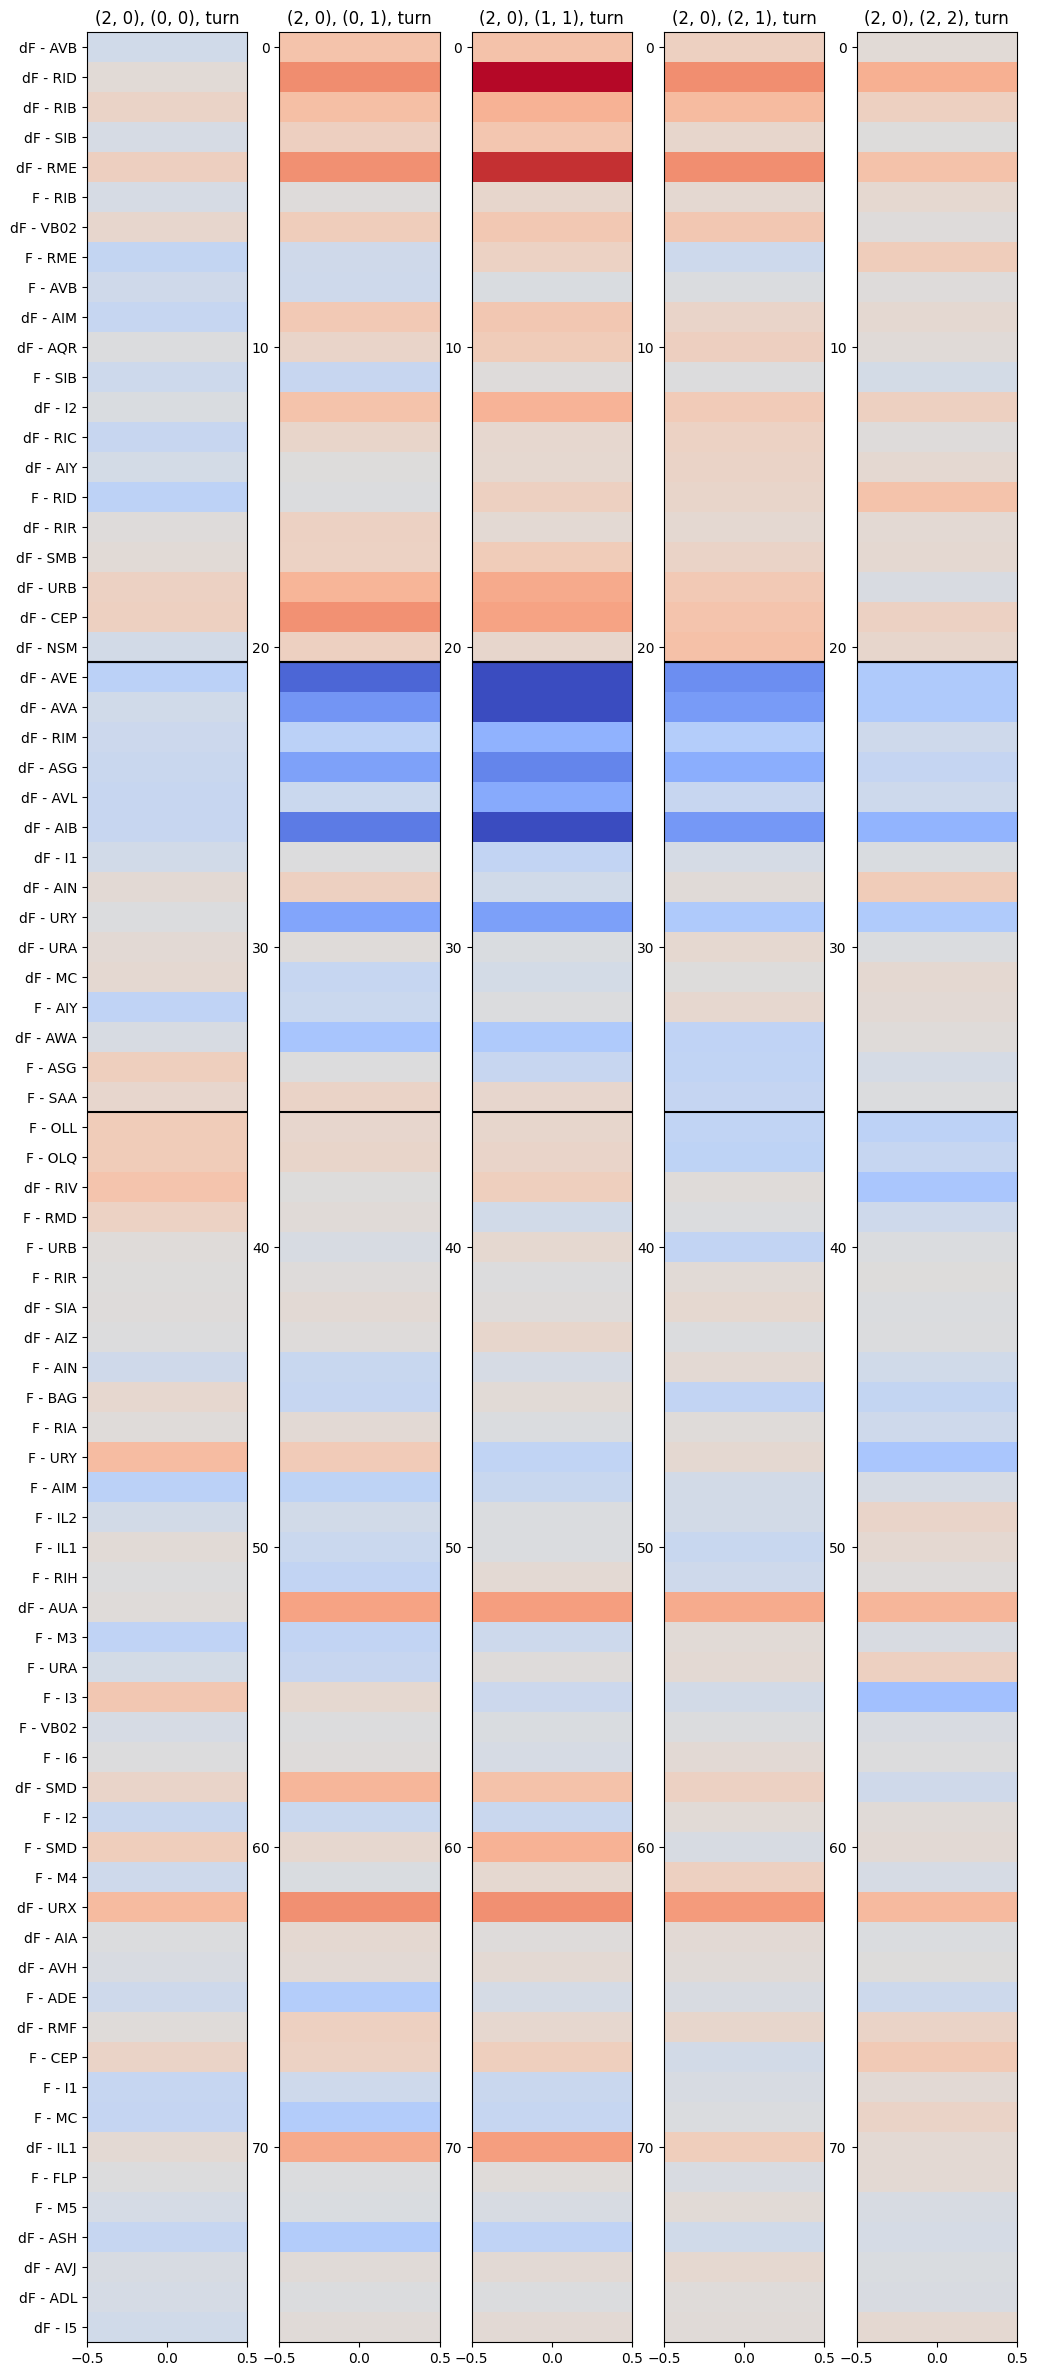

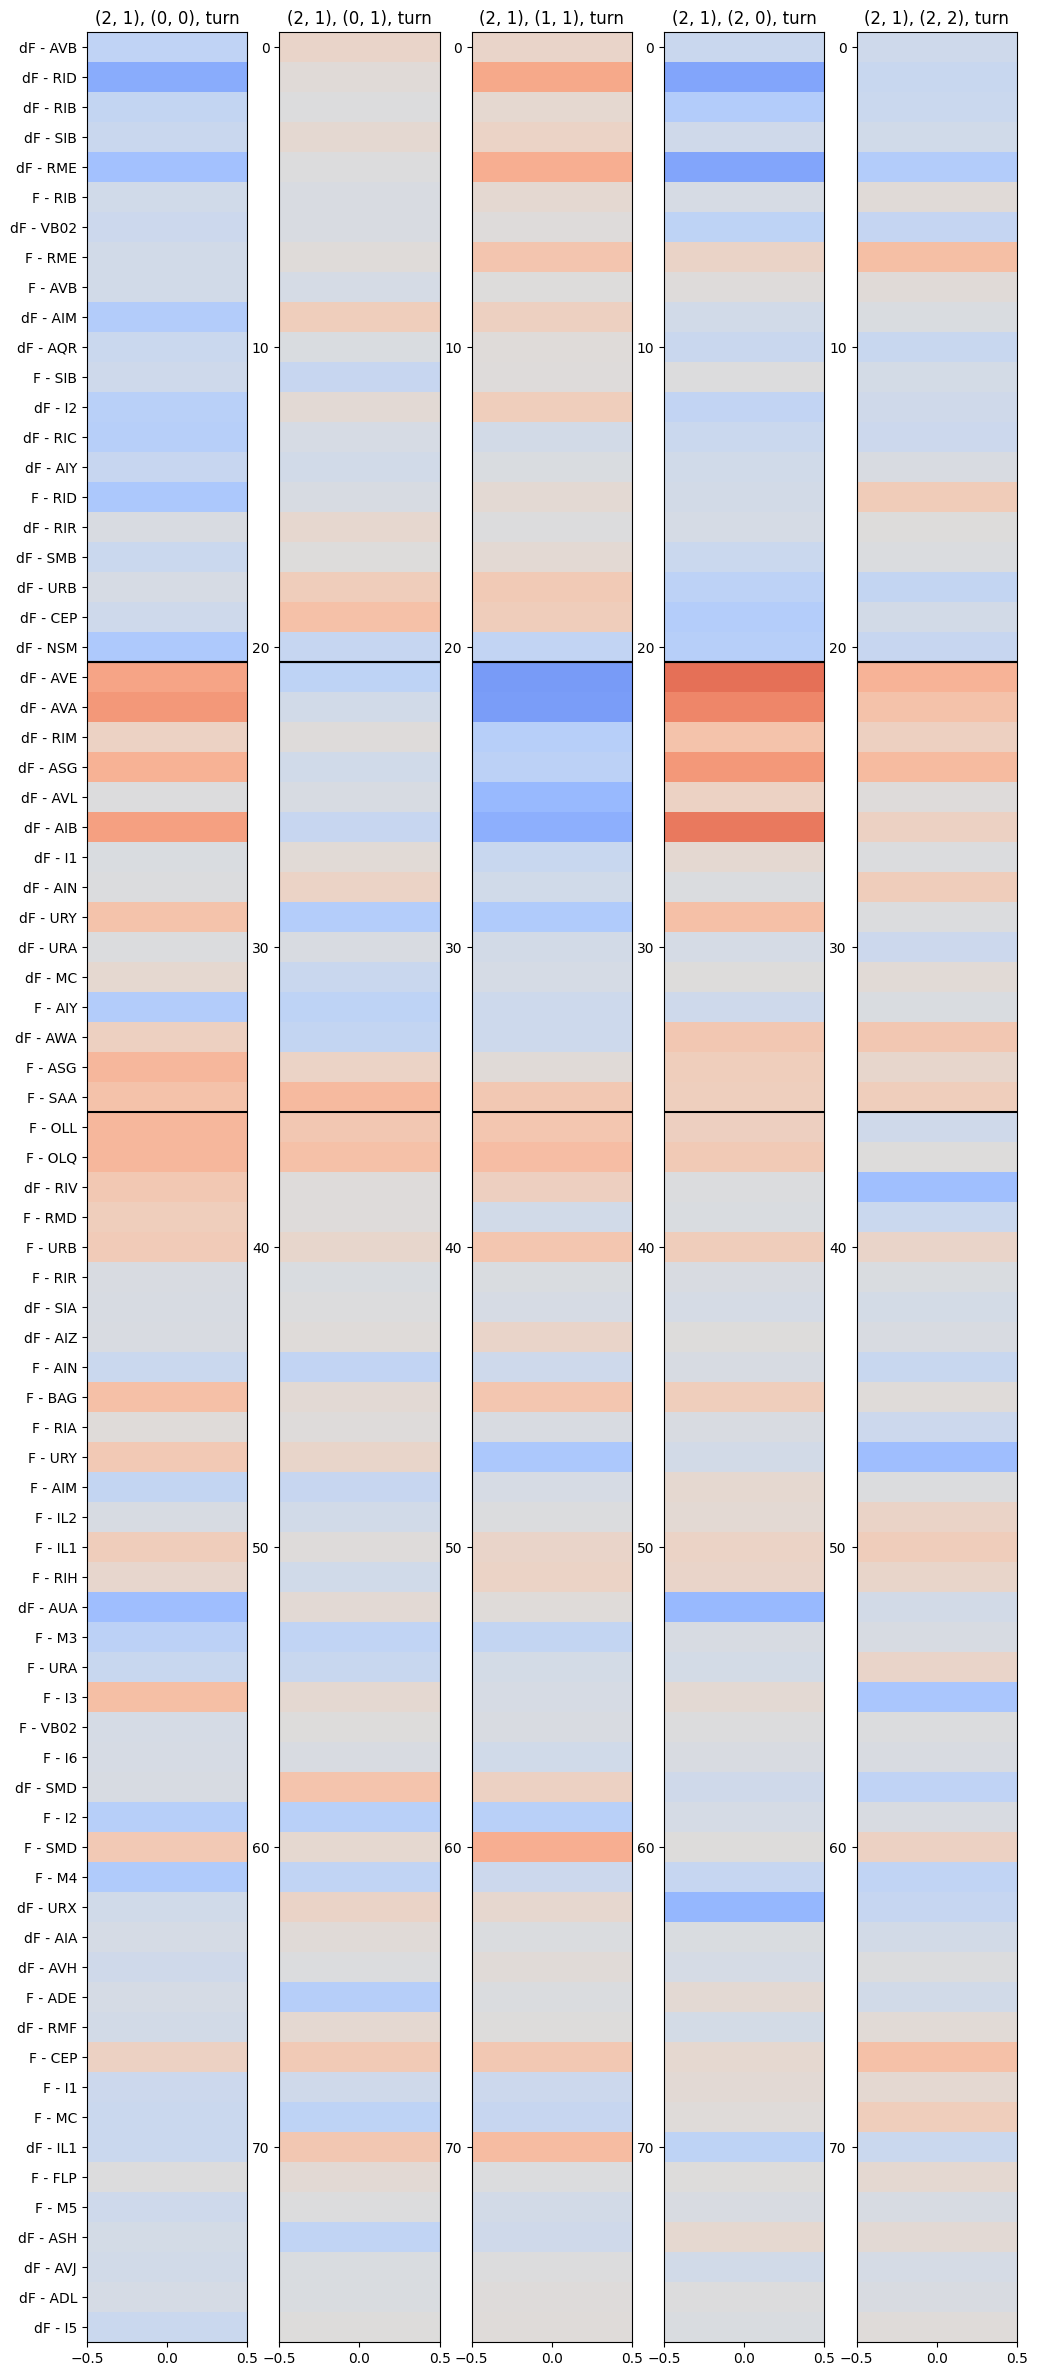

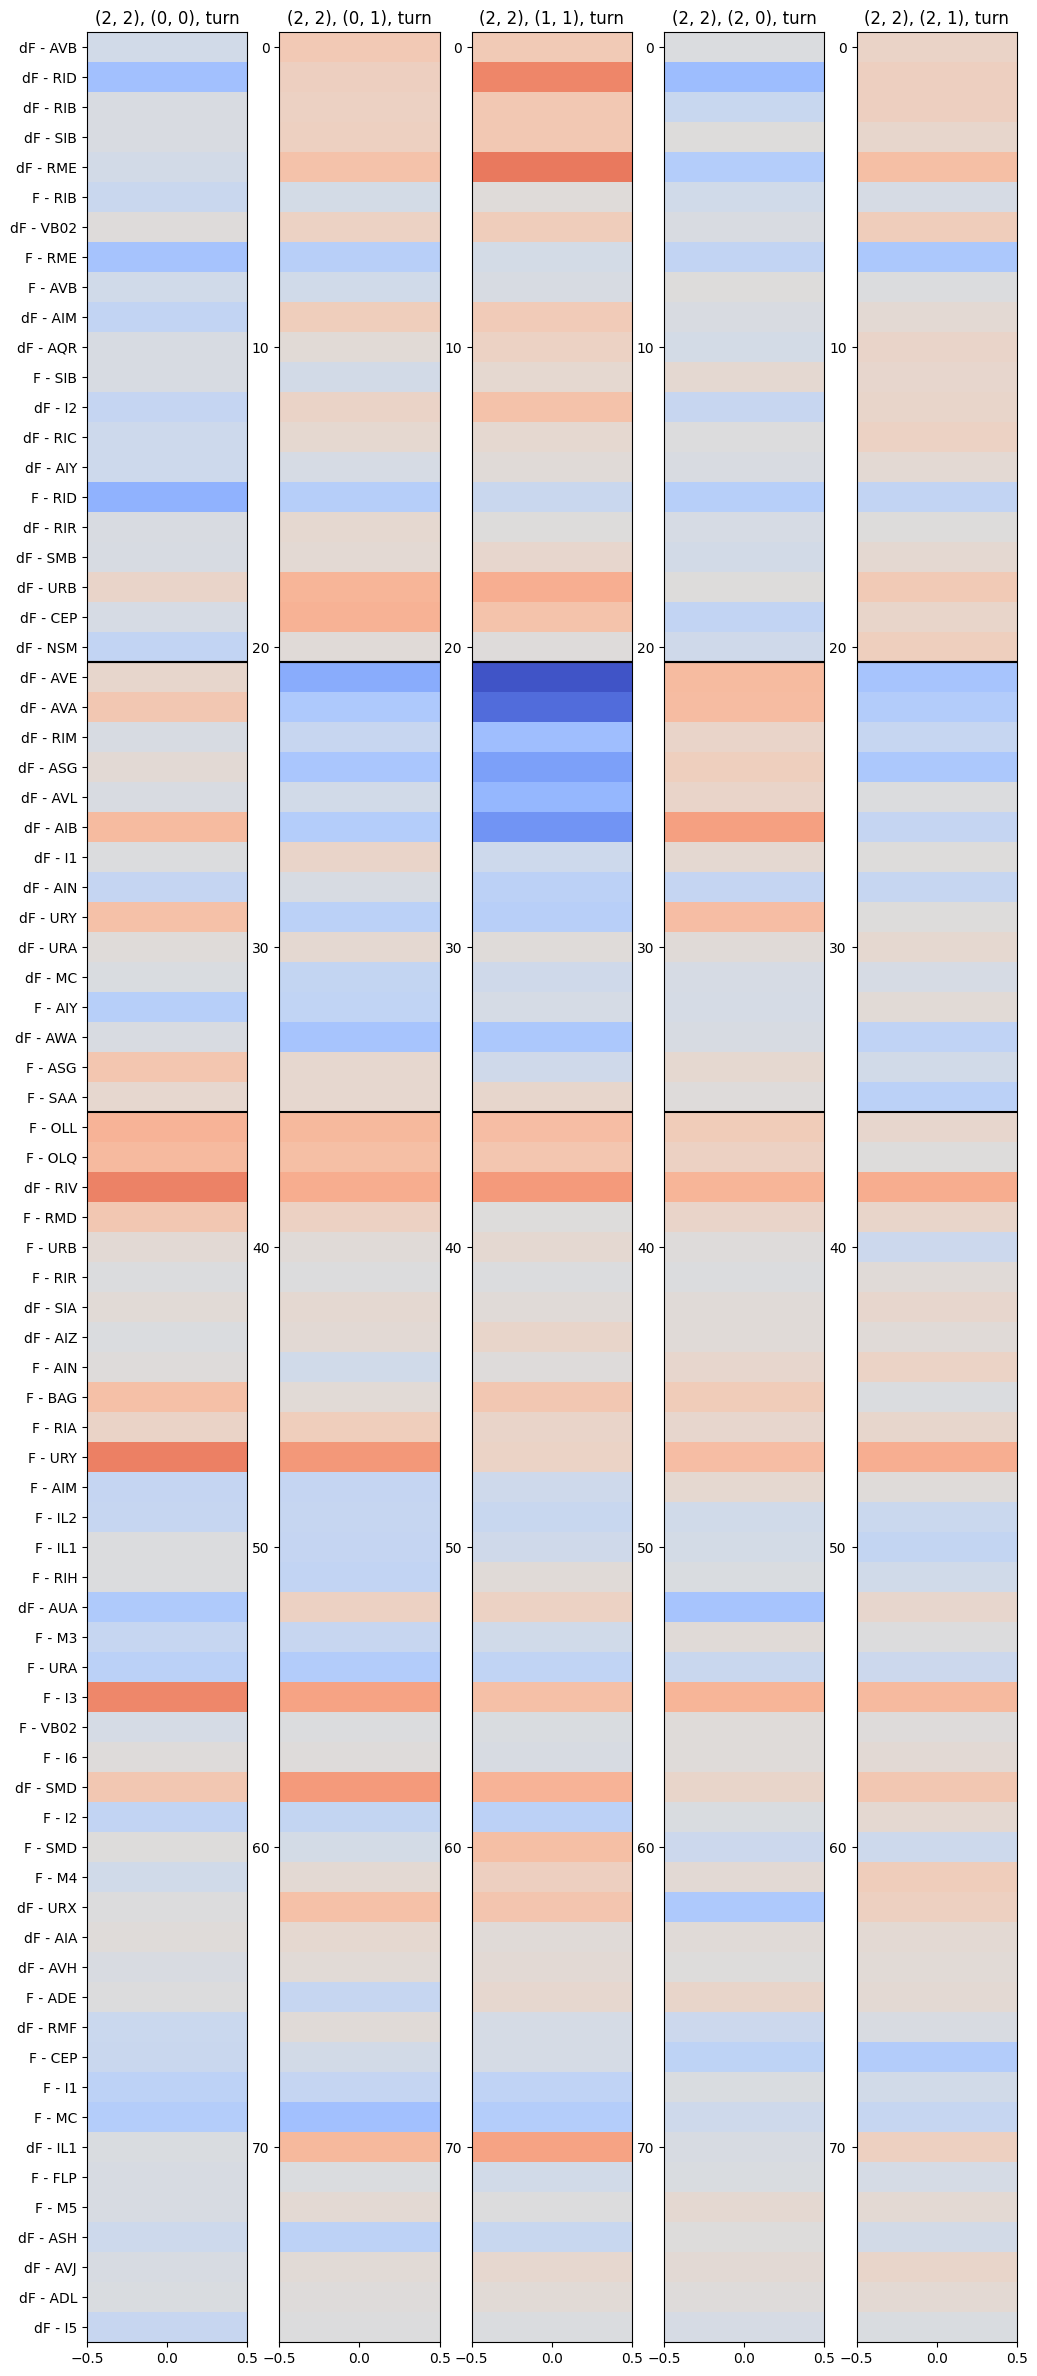

In [ ]:
''' plot neural activity'''

neural_feature_to_dict = {
    "neural_activity_mean":
        {
        # "exp_date_to_feature":  {date: get_body_angle_mag_from_midline(midline)[1][:, 20] for date,midline in exp_date_to_midlines.items() },
        # "bins": np.arange(0, 15, 1), 
         "feature_fnc": lambda neuralseq: np.nanmean(neuralseq, axis = 0), 
         "ylim": [0, 0.5],
          "ylabel": "mean", 
              "feature_mat": np.array(Y)
    },
            "neural_activity_min":
        {
        # "exp_date_to_feature":  {date: get_body_angle_mag_from_midline(midline)[1][:, 20] for date,midline in exp_date_to_midlines.items() },
        # "bins": np.arange(0, 15, 1), 
         "feature_fnc": lambda neuralseq: np.nanmin(neuralseq, axis = 0), 
         "ylim": [0, 0.5],
          "ylabel": "mean", 
              "feature_mat": np.array(Y)
    },
                    "neural_activity_max":
        {
        # "exp_date_to_feature":  {date: get_body_angle_mag_from_midline(midline)[1][:, 20] for date,midline in exp_date_to_midlines.items() },
        # "bins": np.arange(0, 15, 1), 
         "feature_fnc": lambda neuralseq: np.nanmax(neuralseq, axis = 0), 
         "ylim": [0, 0.5],
          "ylabel": "mean", 
              "feature_mat": np.array(Y)
    },
        
    
}


import os
contributor_thres = 0.05
foldername = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/test_rslds_QM_run_061325/model_selection/top_2_combined/"
with open(os.path.join(foldername, f'high_contributing_neurons_rslds_{contributor_thres}.txt')) as f:
    neural_labels_cropped = [line.strip() for line in f]
rslds_states = [0,1,2]
motor_states = [0,1,2]
state_to_label,  state_to_track_start_end_is = get_motor_state_start_end_is_rslds_start_end_specific_1(motor_states, rslds_states, z, q_z)
label_to_state = {val:key for key, val in state_to_label.items()}
plot_neural_activity(neural_feature_to_dict, state_to_track_start_end_is, label_to_state, rslds_states, motor_states, motor_state_num_to_name, neural_labels, neural_labels_cropped)





In [ ]:
state_to_track_start_end_is

{0: array([[   0,  308,  309],
        [   0,  615,  620],
        [   0, 1076, 1087],
        [   0, 1148, 1151],
        [   0, 1264, 1278],
        [   0, 1577, 1581],
        [   1,  135,  157],
        [   1,  578,  647],
        [   1,  911,  923],
        [   1, 1064, 1068],
        [   2,  192,  234],
        [   2,  246,  256],
        [   2,  355,  373],
        [   2,  376,  385],
        [   2,  812,  859],
        [   2, 1328, 1352],
        [   2, 1503, 1534],
        [   2, 1561, 1596],
        [   3,  219,  230],
        [   3,  232,  234],
        [   3, 1514, 1551],
        [   4,  303,  314],
        [   4,  317,  326],
        [   4,  409,  414],
        [   4,  419,  425],
        [   4,  512,  526],
        [   4,  528,  532],
        [   4,  535,  542],
        [   4,  576,  583],
        [   4, 1310, 1322],
        [   4, 1373, 1392],
        [   5,  331,  361],
        [   6,    4,    8],
        [   6,  211,  236],
        [   6,  399,  417],
        [   6,  4

In [ ]:
'''get vids '''

(21, 1599)

In [ ]:
'''seperate if high vs low neural activity '''

dict_items([(0, (0, (0, 0))), (1, (0, (0, 1))), (2, (0, (0, 2))), (3, (0, (1, 0))), (4, (0, (1, 1))), (5, (0, (1, 2))), (6, (0, (2, 0))), (7, (0, (2, 1))), (8, (0, (2, 2))), (9, (1, (0, 0))), (10, (1, (0, 1))), (11, (1, (0, 2))), (12, (1, (1, 0))), (13, (1, (1, 1))), (14, (1, (1, 2))), (15, (1, (2, 0))), (16, (1, (2, 1))), (17, (1, (2, 2))), (18, (2, (0, 0))), (19, (2, (0, 1))), (20, (2, (0, 2))), (21, (2, (1, 0))), (22, (2, (1, 1))), (23, (2, (1, 2))), (24, (2, (2, 0))), (25, (2, (2, 1))), (26, (2, (2, 2)))])